# Go through dataset

In [1]:
COMP_NAME = "used_car_price_prediction"

In [2]:
from pathlib import Path
CUR_DIR = Path("__file__").resolve().parent
ROOT_DIR = CUR_DIR.parent
INP_DIR = ROOT_DIR / "input" / COMP_NAME

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

In [4]:
!ls ../input/used_car_price_prediction

submit_sample.csv test.csv          train.csv


In [5]:
INP_DIR

PosixPath('/Users/takumiwatanabe/signate/used_car_price_prediction/input/used_car_price_prediction')

In [6]:
train = pd.read_csv(INP_DIR / "train.csv")
test = pd.read_csv(INP_DIR / "test.csv")
SUB = pd.read_csv(INP_DIR / "submit_sample.csv")

In [7]:
# 15種類の変数, train/testともに 27,537 レコード
train.shape, test.shape

((27532, 16), (27537, 15))

In [8]:
train.head()

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158


### 欠損
- fuel, title_status, type, state に欠損あり

In [9]:
train.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1239
odometer           0
title_status     456
transmission       0
drive              0
size               0
type             456
paint_color        0
state           3304
price              0
dtype: int64

In [10]:
test.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1495
odometer           0
title_status     229
transmission       0
drive              0
size               0
type             229
paint_color        0
state           3029
dtype: int64

### id (中古車の識別番号)

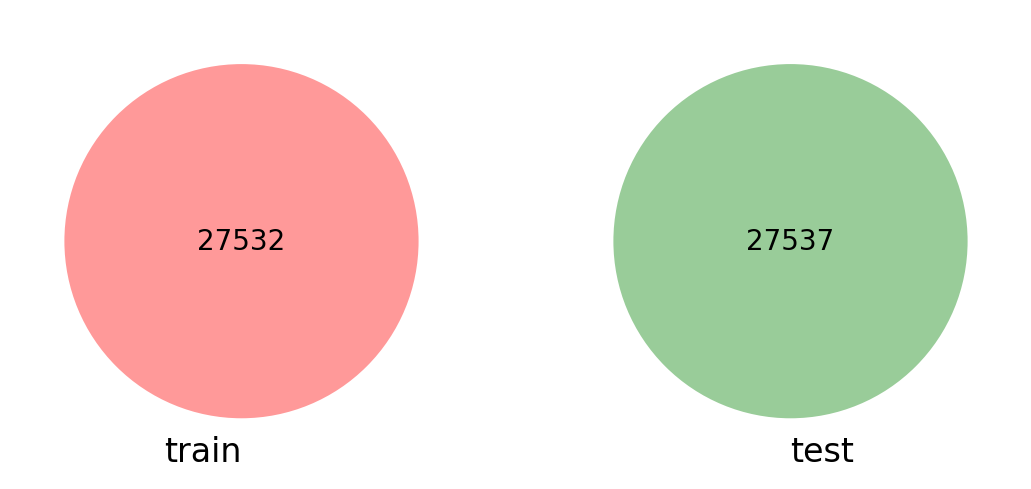

In [27]:
# train/testの重複はなし
venn2([set(train.id), set(test.id)], set_labels = ("train", "test"));

### region (販売地域) 

In [42]:
# 372 の地域, 全てアメリカっぽい
train.region.nunique(), test.region.nunique()

(372, 372)

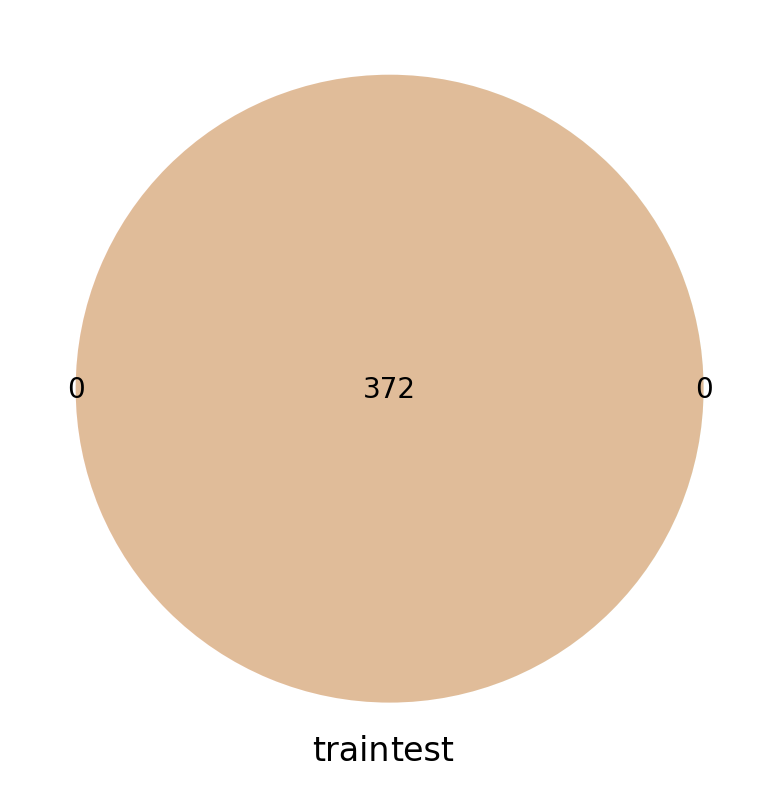

In [36]:
# train/test で全て同じ
venn2([set(train.region), set(test.region)], set_labels = ("train", "test"));

<Axes: xlabel='region'>

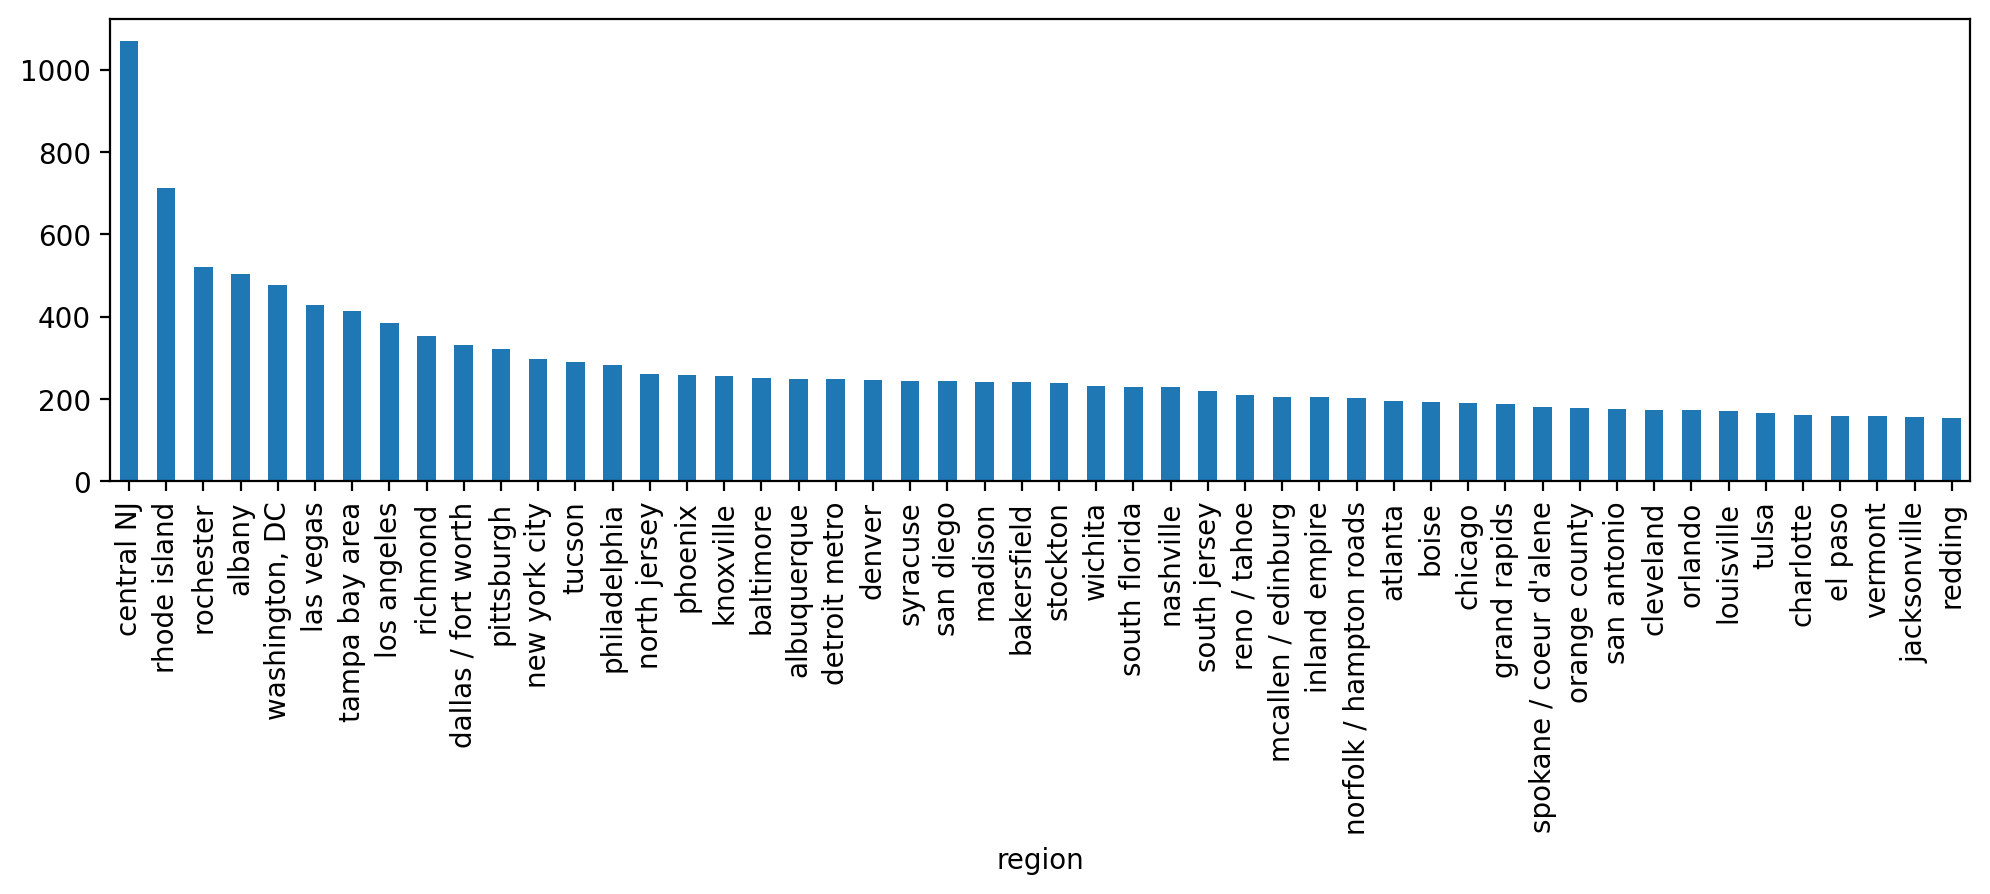

In [40]:
train.region.value_counts().head(50).plot(kind="bar", figsize=(12, 3))

<Axes: xlabel='region'>

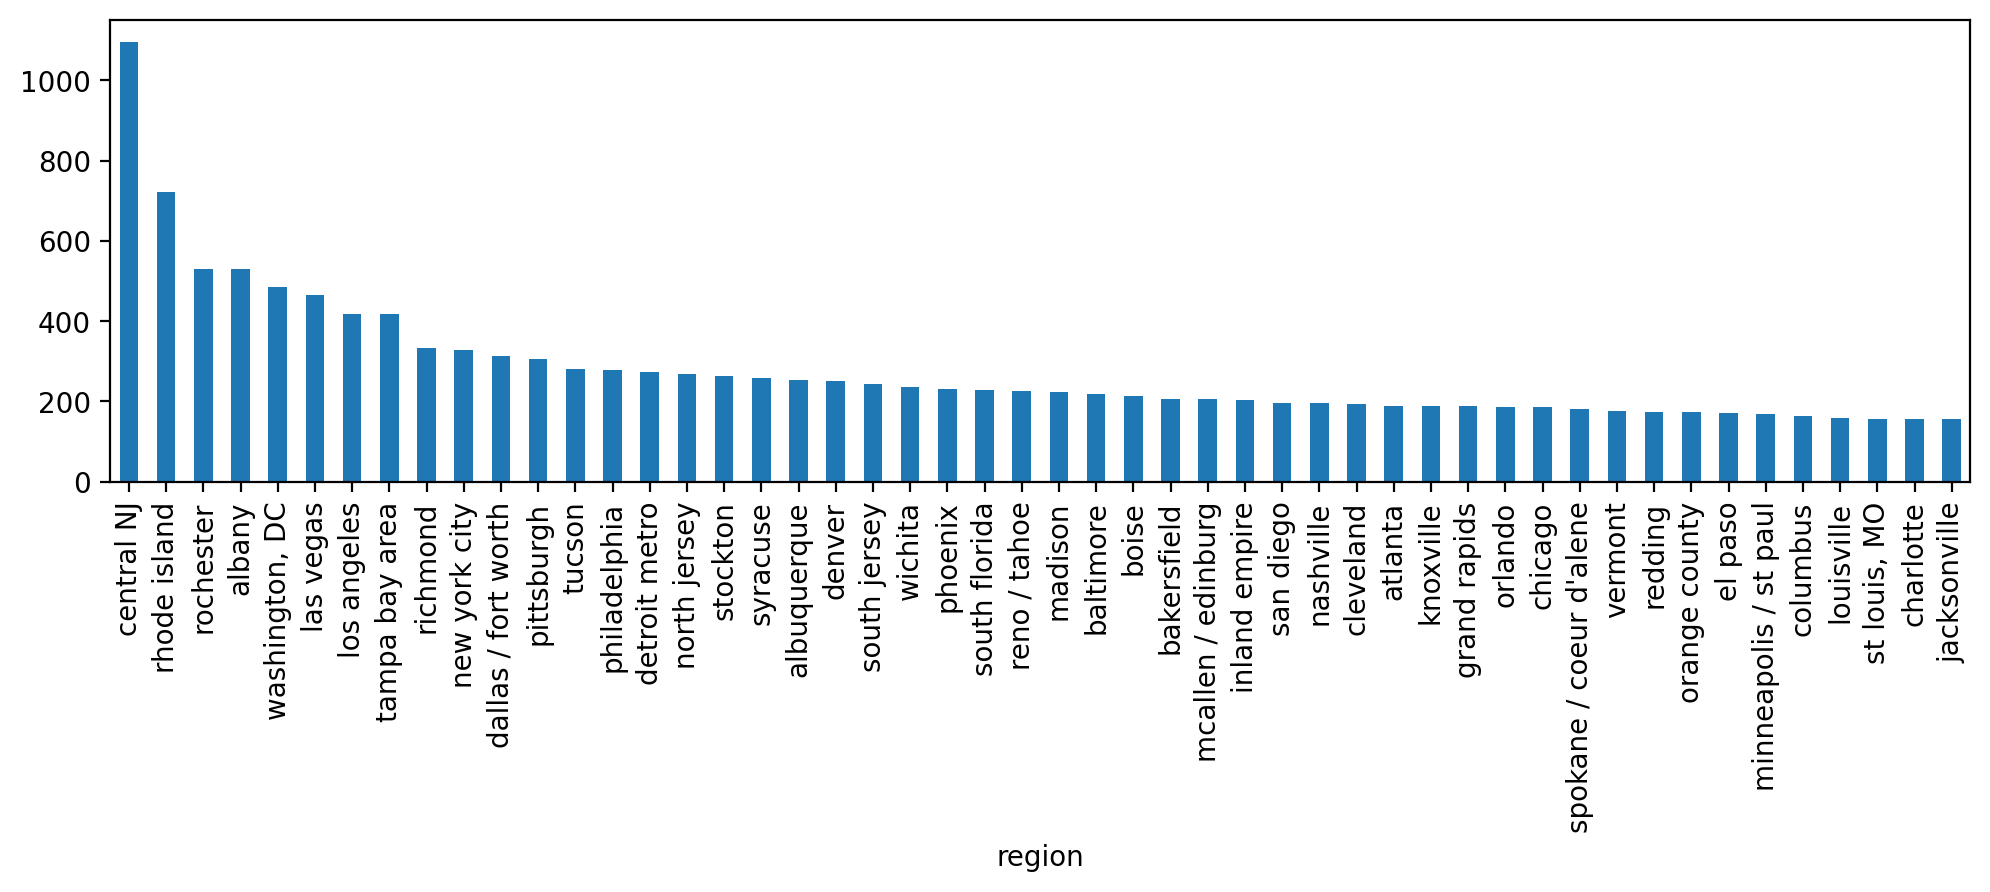

In [41]:
test.region.value_counts().head(50).plot(kind="bar", figsize=(12, 3))

### state (販売州)

In [44]:
# 51 の州, アメリカの全50州 + ワシントンD.C.
train.state.nunique(), test.state.nunique()

(51, 51)

In [50]:
len(set(train.state))

52

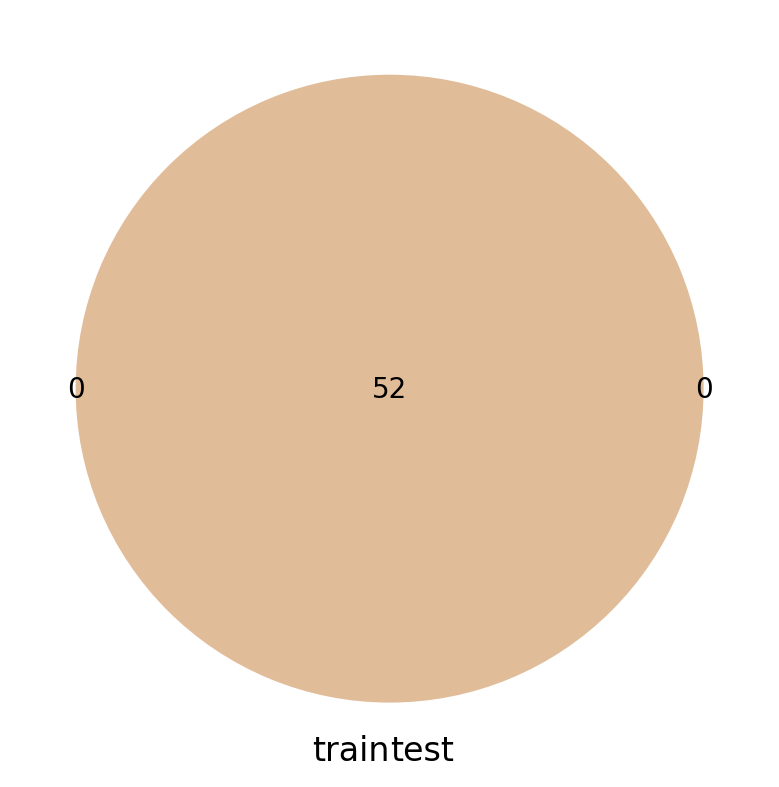

In [45]:
# train/test で全て同じ
venn2([set(train.state), set(test.state)], set_labels = ("train", "test"));

In [48]:
len(set(train.state) | set(test.state))

52

### year (製造年)

In [37]:
train.year.describe()

count    27532.000000
mean      2007.832958
std         15.758976
min       1921.000000
25%       2005.000000
50%       2011.000000
75%       2014.000000
max       3017.000000
Name: year, dtype: float64

In [38]:
test.year.describe()

count    27537.000000
mean      2007.838908
std         14.558094
min       1918.000000
25%       2005.000000
50%       2011.000000
75%       2014.000000
max       3019.000000
Name: year, dtype: float64

In [13]:
# train と test で差がある
train.year.nunique(), test.year.nunique()

(101, 103)

In [34]:
# train: 1921-2022, 2999 以降はミスっぽい, 2000年前後に直せば良さそう, 低年式すぎるものは、メーカーごとの分布と比較で外れすぎてたら処理してもいいかも, 保管はまずそう
train.year.value_counts().sort_index()

year
1921    1
1922    2
1925    2
1928    2
1929    1
       ..
2022    5
2999    1
3008    1
3015    1
3017    1
Name: count, Length: 101, dtype: int64

In [28]:
# test: 1918-2022, 3011 以降はミスっぽい, 2000年前後に直せば良さそう
test.year.value_counts().sort_index()

year
1918     1
1920     2
1921     1
1923     1
1926     1
        ..
2021    34
2022     2
3011     1
3015     1
3019     1
Name: count, Length: 103, dtype: int64

In [29]:
map_year_future = lambda x: x if x < 2025 else x - 1000

<Axes: xlabel='year'>

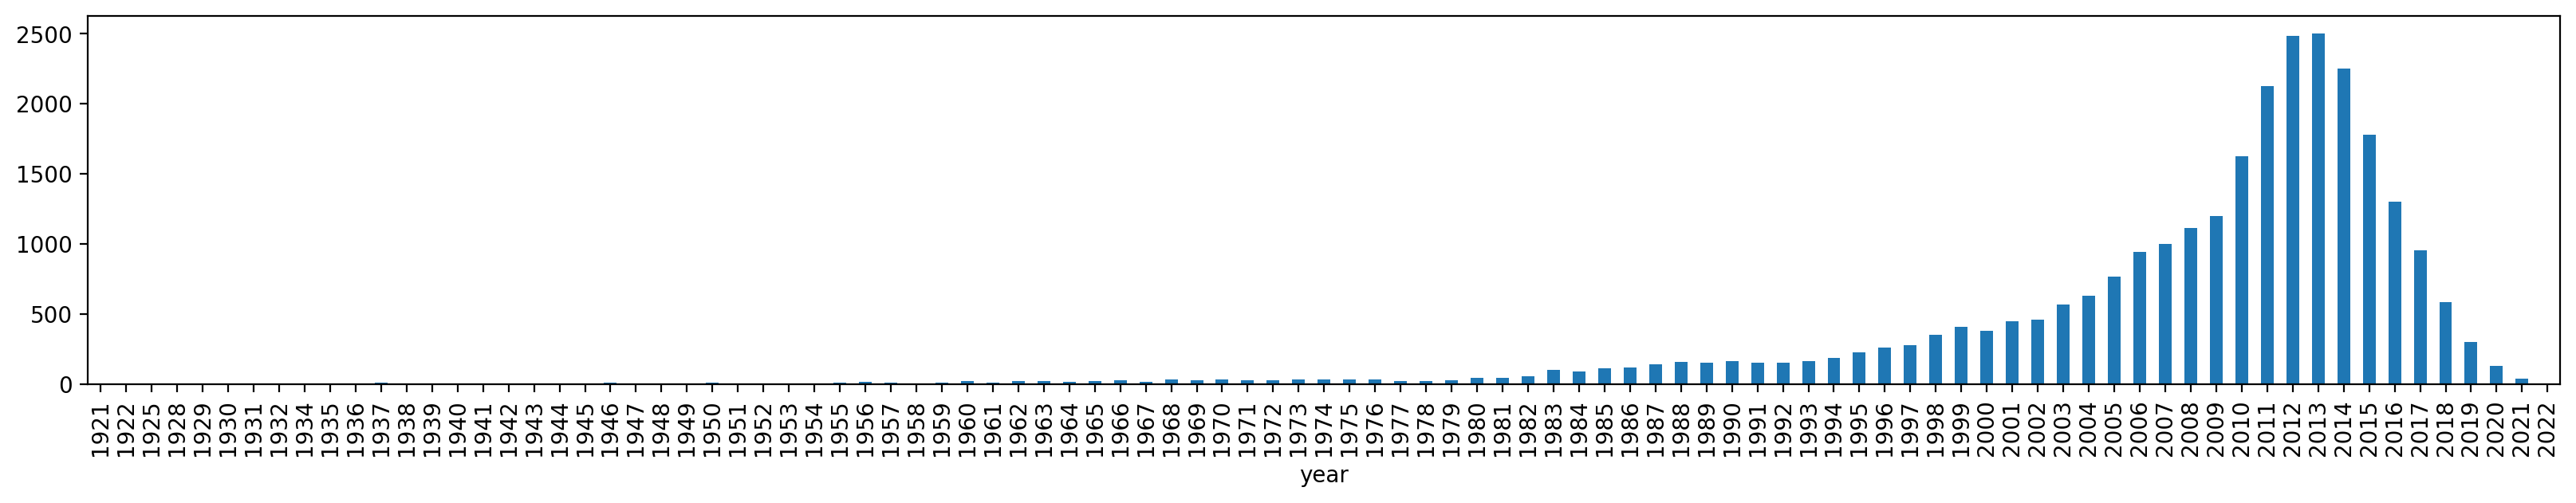

In [33]:
train.year.map(map_year_future).value_counts().sort_index().plot(kind="bar", figsize=(20, 3))

<Axes: xlabel='year'>

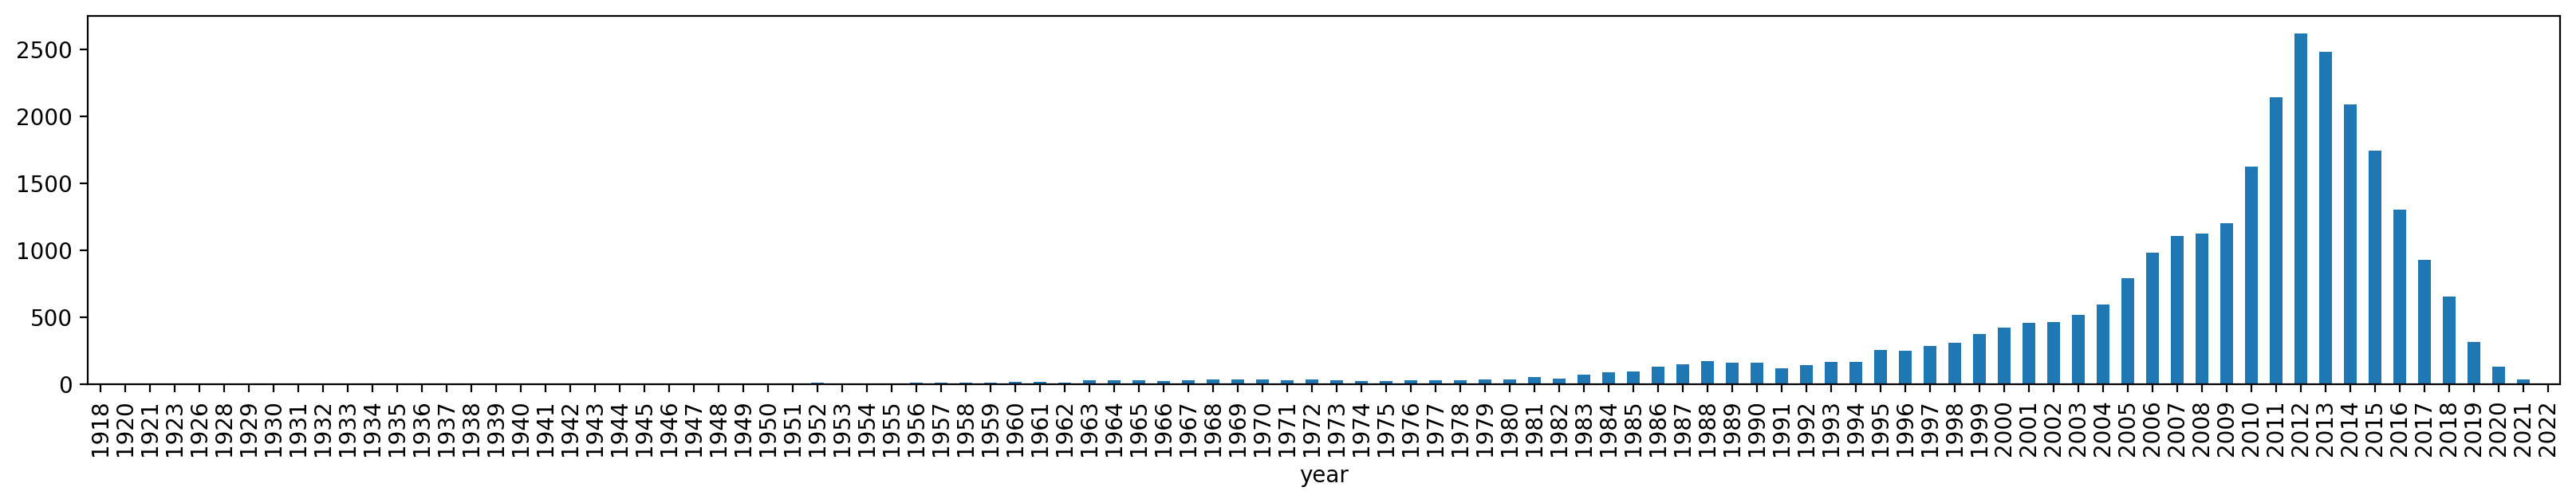

In [35]:
test.year.map(map_year_future).value_counts().sort_index().plot(kind="bar", figsize=(20, 3))

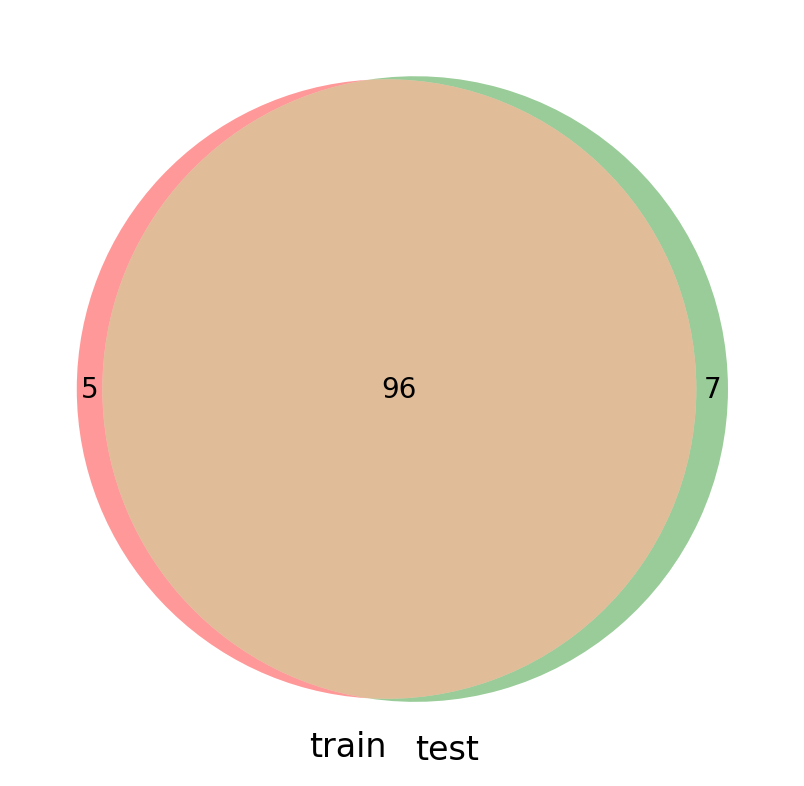

In [22]:
# train/test でだいたい被ってる
venn2([set(train.year), set(test.year)], set_labels = ("train", "test"));

### odometer (走行距離)

In [39]:
# マイナスがあるので処理が必要
train.odometer.describe()

count    2.753200e+04
mean     1.160199e+05
std      6.451642e+04
min     -1.318690e+05
25%      7.836775e+04
50%      1.114445e+05
75%      1.508562e+05
max      2.946000e+06
Name: odometer, dtype: float64

In [40]:
# train と test で差がある
test.odometer.describe()

count     27537.000000
mean     116592.779932
std       59040.921780
min          -1.000000
25%       79914.000000
50%      112436.000000
75%      150338.000000
max      394595.000000
Name: odometer, dtype: float64

<Axes: ylabel='Frequency'>

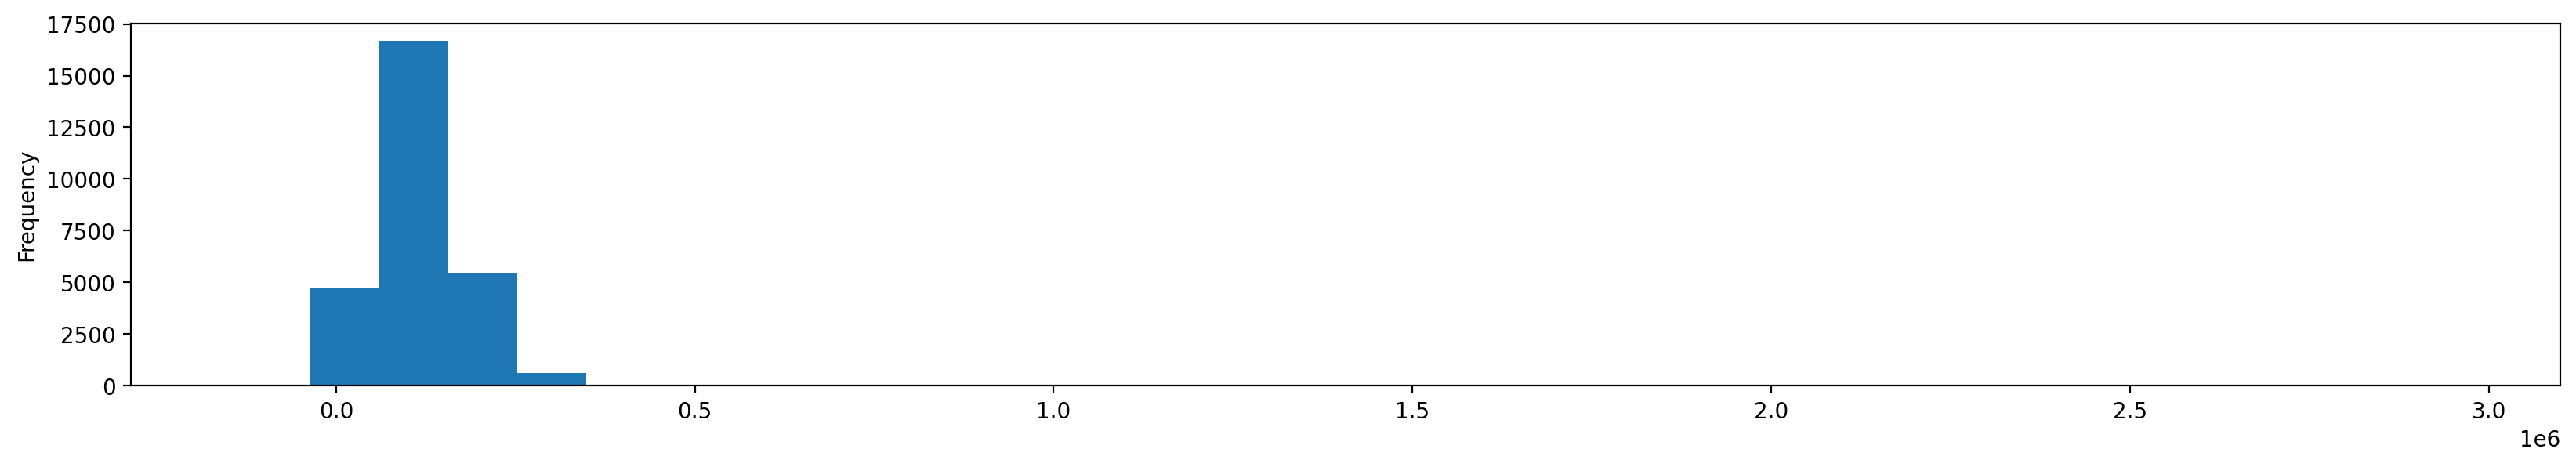

In [71]:
# 極端に走行距離が長いものがある
train.odometer.plot(kind="hist", bins=32, figsize=(20, 3))

In [ ]:
2946000 

In [73]:
# 2946000 miles = 4,741,127km (4００万キロ), CSnetで100万キロ超があるので、400万キロもあり得そう
train.odometer.sort_values()

759      -131869
11764         -1
18363         -1
5883          -1
20875         -1
          ...   
6925     1187840
6829     1233280
12549    1484310
10576    1638440
1775     2946000
Name: odometer, Length: 27532, dtype: int64

<Axes: xlabel='year'>

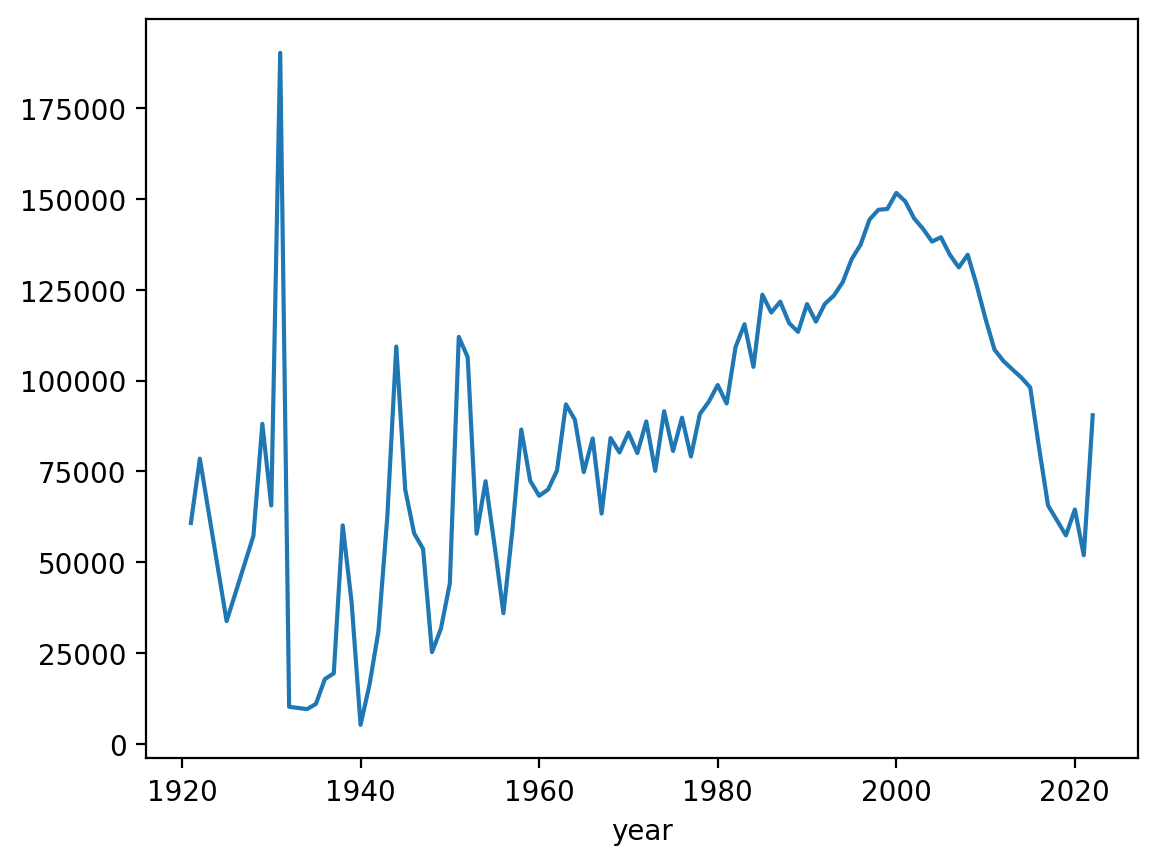

In [54]:
train[["year", "odometer"]].query("year < 2500 & 0 <= odometer < 1e+6").groupby("year").odometer.median().sort_index().plot()

<Axes: ylabel='Frequency'>

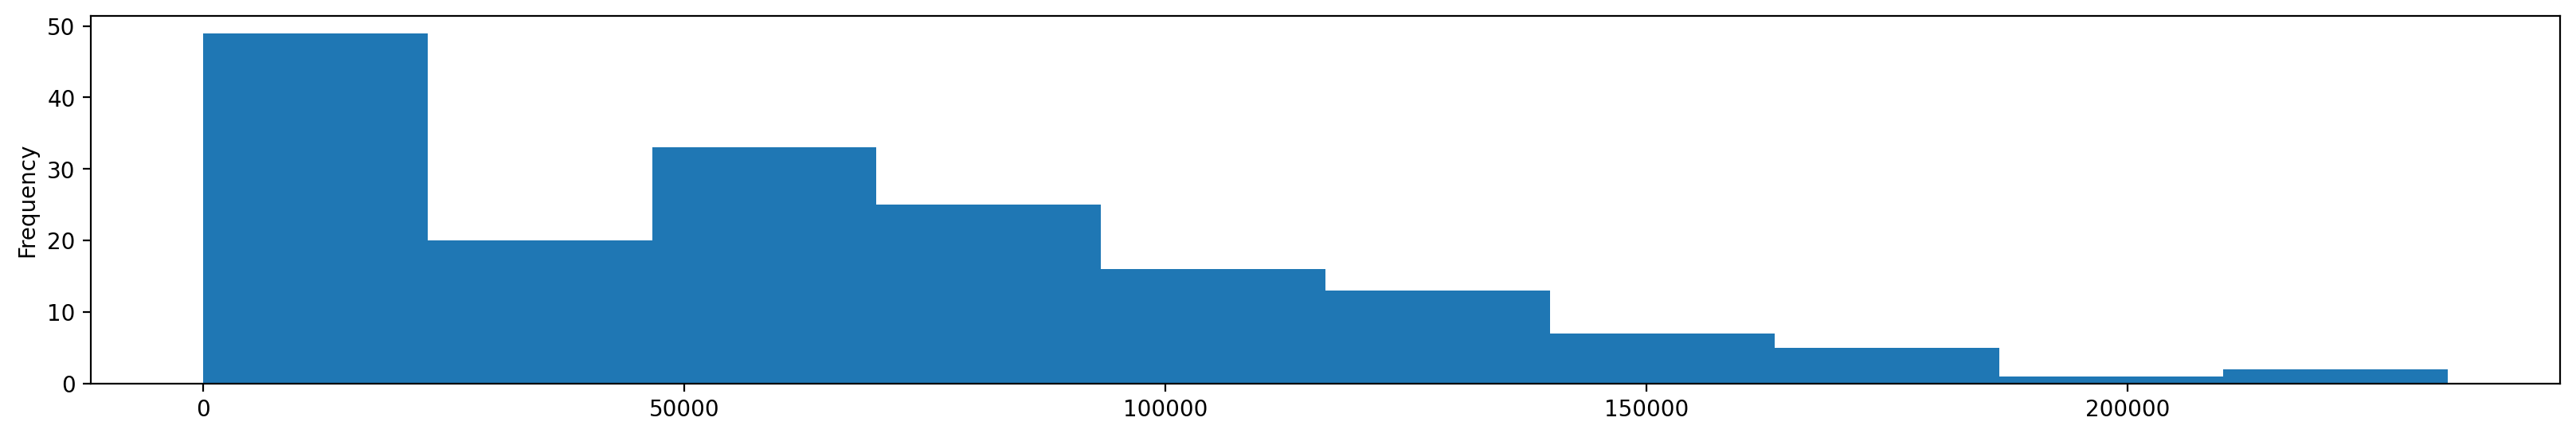

In [55]:
# 1-2年落ちの走行距離
train.query("2020 <= year <= 2022").odometer.plot(kind="hist", figsize=(20, 3))

In [56]:
train.query("2020 <= year <= 2022").odometer.describe()

count       171.000000
mean      64655.859649
std       51257.066772
min          -1.000000
25%       19298.000000
50%       60679.000000
75%       95239.500000
max      233276.000000
Name: odometer, dtype: float64

In [57]:
# 3-5年落ち
train.query("2017 <= year <= 2019").odometer.describe()

count      1836.000000
mean      74963.893246
std       57845.681182
min          -1.000000
25%       29949.750000
50%       62697.500000
75%      109658.500000
max      396512.000000
Name: odometer, dtype: float64

In [59]:
train.manufacturer.value_counts()

manufacturer
ford          6166
chevrolet     3339
bmw           2736
toyota        1570
honda         1526
              ... 
ｓａｔｕｒｎ           1
ＭＩＴＳＵＢＩＳＨＩ       1
lexuѕ            1
ＭＥＲＣＵＲＹ          1
ᴄhrysler         1
Name: count, Length: 125, dtype: int64

### price (販売価格)

In [74]:
train.price.describe()

count    27532.000000
mean     13468.724829
std      10962.149840
min       1004.000000
25%       5759.000000
50%       9206.000000
75%      19128.000000
max      96818.000000
Name: price, dtype: float64

<Axes: ylabel='Frequency'>

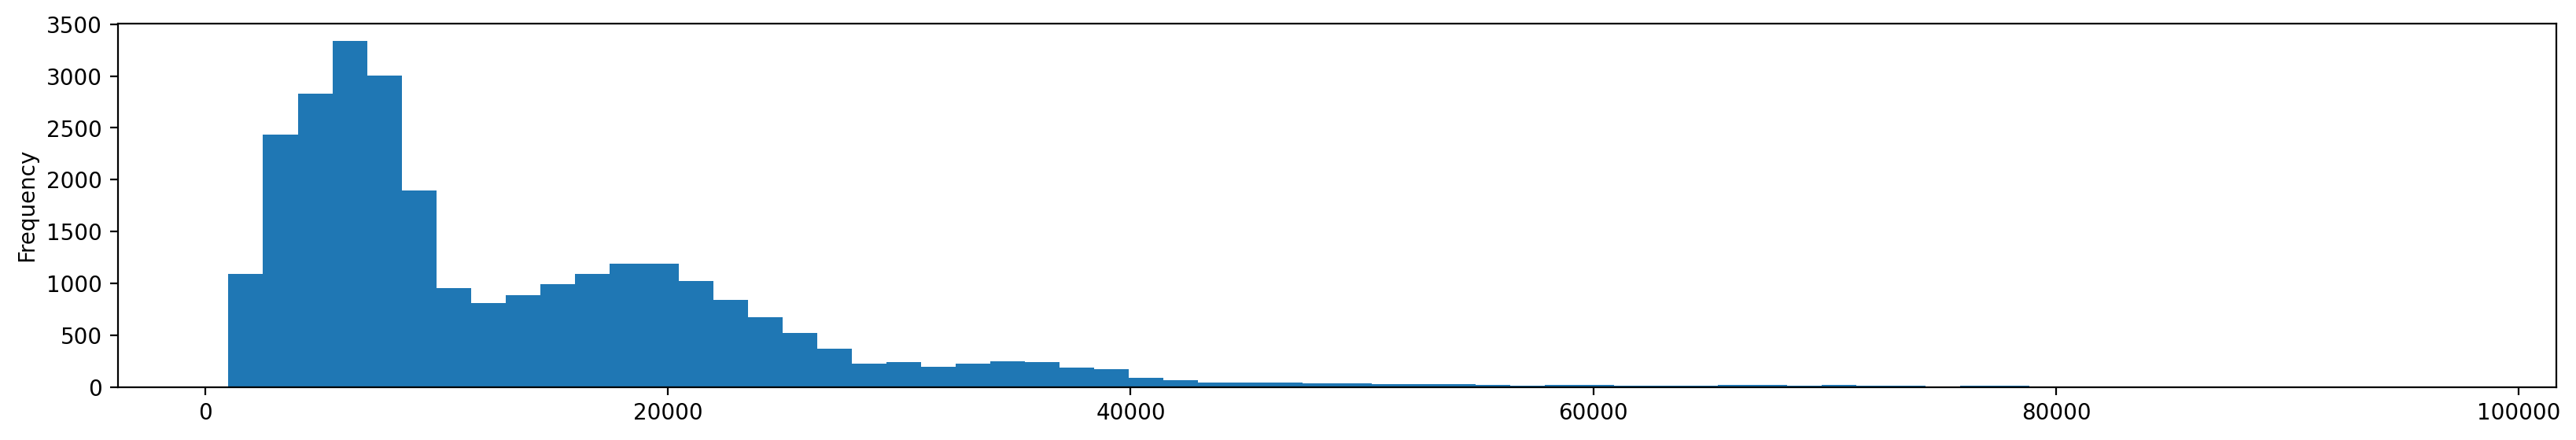

In [76]:
train.price.plot(kind="hist", bins=64, figsize=(20, 3))

<Axes: ylabel='Frequency'>

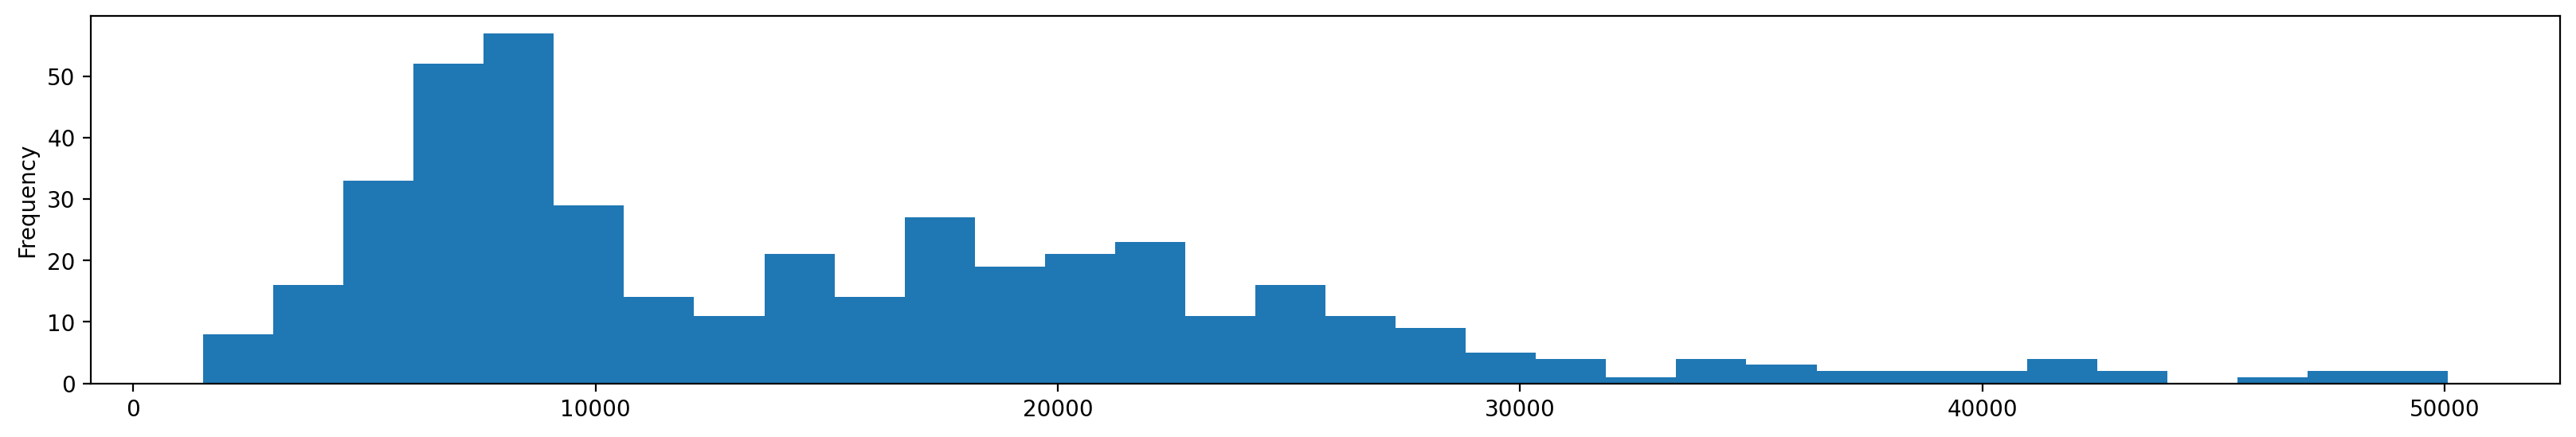

In [70]:
# 単位はドルっぽい
train.query("manufacturer == 'ford' and 2010 <= year <= 2013 and type == 'SUV'").price.plot(kind="hist", bins=32, figsize=(20, 3))

$1 = ¥130

### manufacturer (製造メーカー)

In [103]:
import unicodedata
str_map = str.maketrans("аαᴄоѕ", "aacos")

In [79]:
# raw
train.manufacturer.nunique(), test.manufacturer.nunique()

(125, 125)

In [89]:
# 全角を半角に変換
train.manufacturer.map(lambda x: unicodedata.normalize("NFKC", x)).nunique(), test.manufacturer.map(lambda x: unicodedata.normalize("NFKC", x)).nunique()

(79, 79)

In [95]:
# 全角を半角に変換 + 大文字を小文字に変換
train.manufacturer.map(lambda x: unicodedata.normalize("NFKC", x).lower()).nunique(), test.manufacturer.map(lambda x: unicodedata.normalize("NFKC", x).lower()).nunique()

(46, 46)

In [104]:
# 全角を半角に変換 + 大文字を小文字に変換 + 名寄せ
train.manufacturer.map(lambda x: unicodedata.normalize("NFKC", x).lower().translate(str_map)).nunique(), test.manufacturer.map(lambda x: unicodedata.normalize("NFKC", x).lower().translate(str_map)).nunique()

(37, 37)

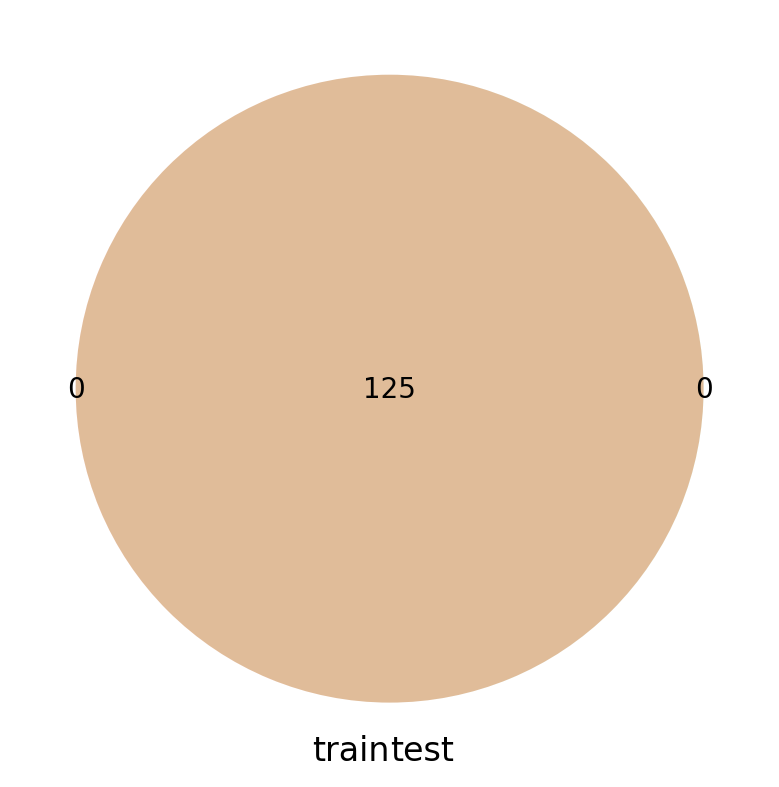

In [105]:
# train/test で全て同じ
venn2([set(train.manufacturer), set(test.manufacturer)], set_labels = ("train", "test"))

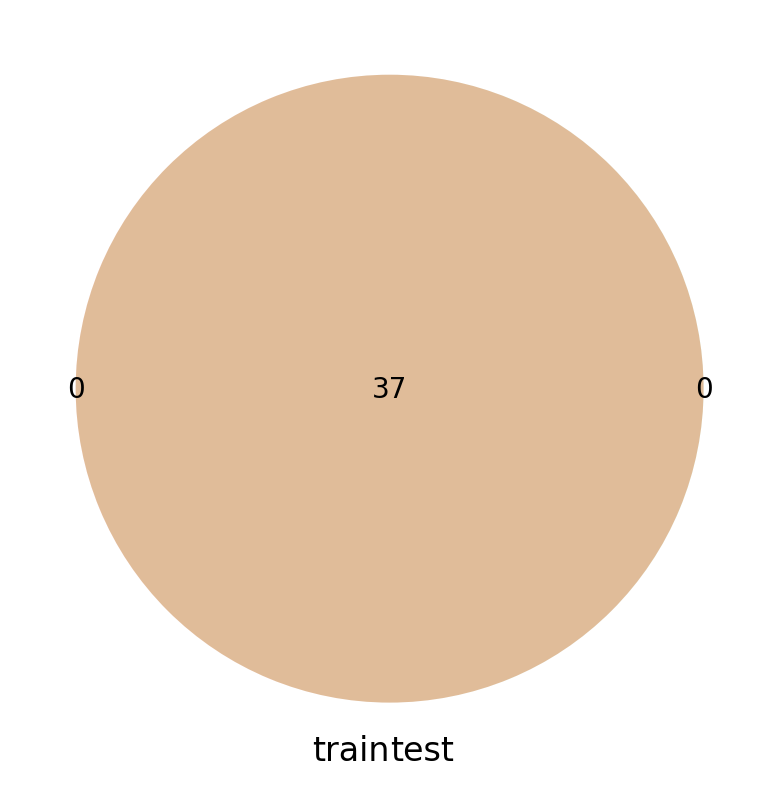

In [106]:
# train/test で全て同じ
venn2([set(train.manufacturer.map(lambda x: unicodedata.normalize("NFKC", x).lower().translate(str_map))), set(test.manufacturer.map(lambda x: unicodedata.normalize("NFKC", x).lower().translate(str_map)))], set_labels = ("train", "test"))

In [83]:
# 名寄せが必要, e.g. 'SUBΑRU', 'subaru', 'ｓｕｂａｒｕ', 'ＳＵＢＡＲＵ', 'SUBARU'
train.manufacturer.value_counts()

manufacturer
ford          6166
chevrolet     3339
bmw           2736
toyota        1570
honda         1526
              ... 
ｓａｔｕｒｎ           1
ＭＩＴＳＵＢＩＳＨＩ       1
lexuѕ            1
ＭＥＲＣＵＲＹ          1
ᴄhrysler         1
Name: count, Length: 125, dtype: int64

In [107]:
train.manufacturer.map(lambda x: unicodedata.normalize("NFKC", x).lower().translate(str_map)).value_counts()

manufacturer
ford             6943
chevrolet        3807
bmw              3044
toyota           1784
honda            1742
ram              1639
jeep             1297
nissan           1003
volkswagen        773
buick             678
kia               668
dodge             433
hyundai           391
gmc               370
audi              329
mazda             327
subaru            290
chrysler          237
acura             224
mitsubishi        206
cadillac          204
mercedes-benz     199
lexus             187
mercury           155
lincoln           152
pontiac           145
infiniti           73
volvo              60
fiat               43
saturn             42
mini               37
rover              18
jaguar             12
porsche            12
alfa-romeo          4
land rover          2
aston-martin        2
Name: count, dtype: int64

<Axes: xlabel='manufacturer'>

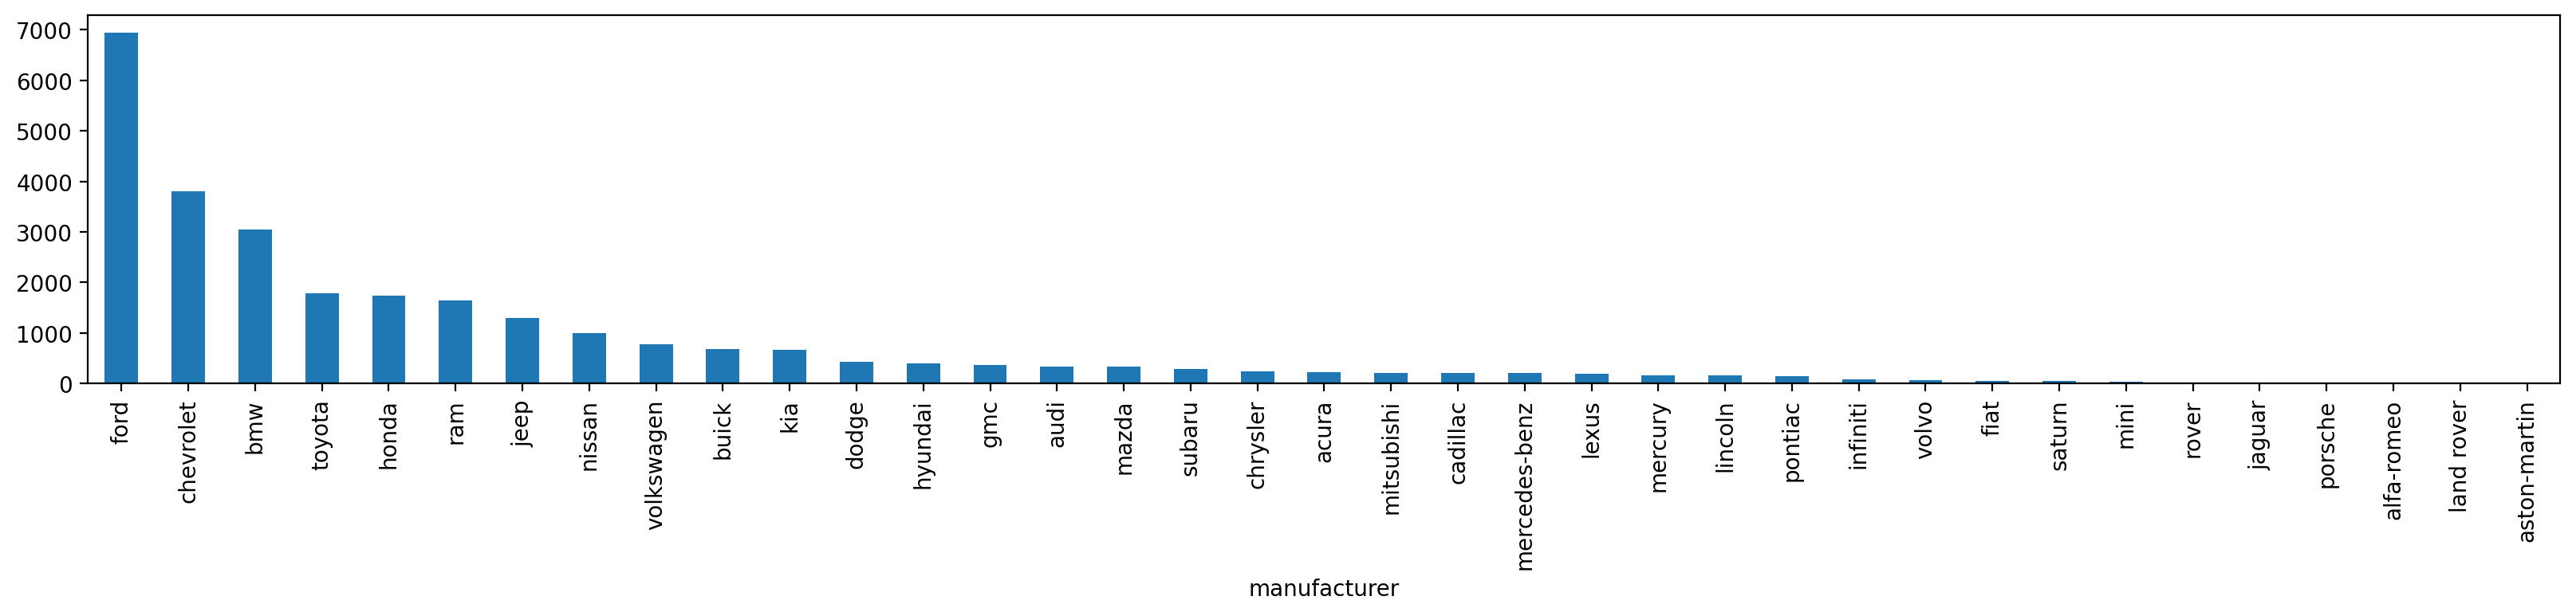

In [111]:
train.manufacturer.map(lambda x: unicodedata.normalize("NFKC", x).lower().translate(str_map)).value_counts().plot(kind="bar", figsize=(20, 3))

### type (ボディタイプ)

In [112]:
# 13種類
train.type.nunique(), test.type.nunique()

(13, 13)

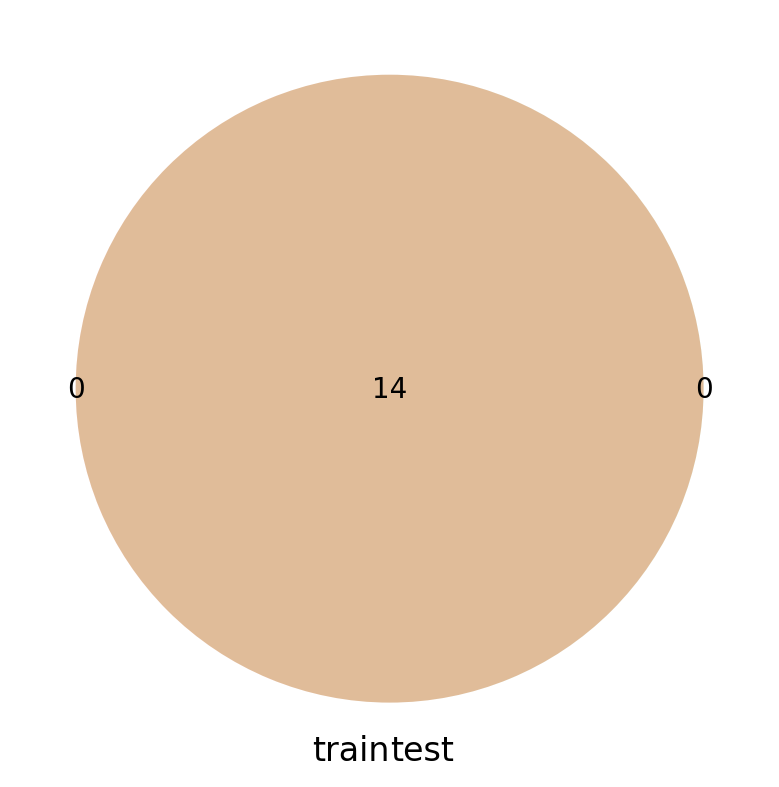

In [115]:
# train/test で全て同じ, 欠損あり
venn2([set(train.type), set(test.type)], set_labels = ("train", "test"))

<Axes: xlabel='type'>

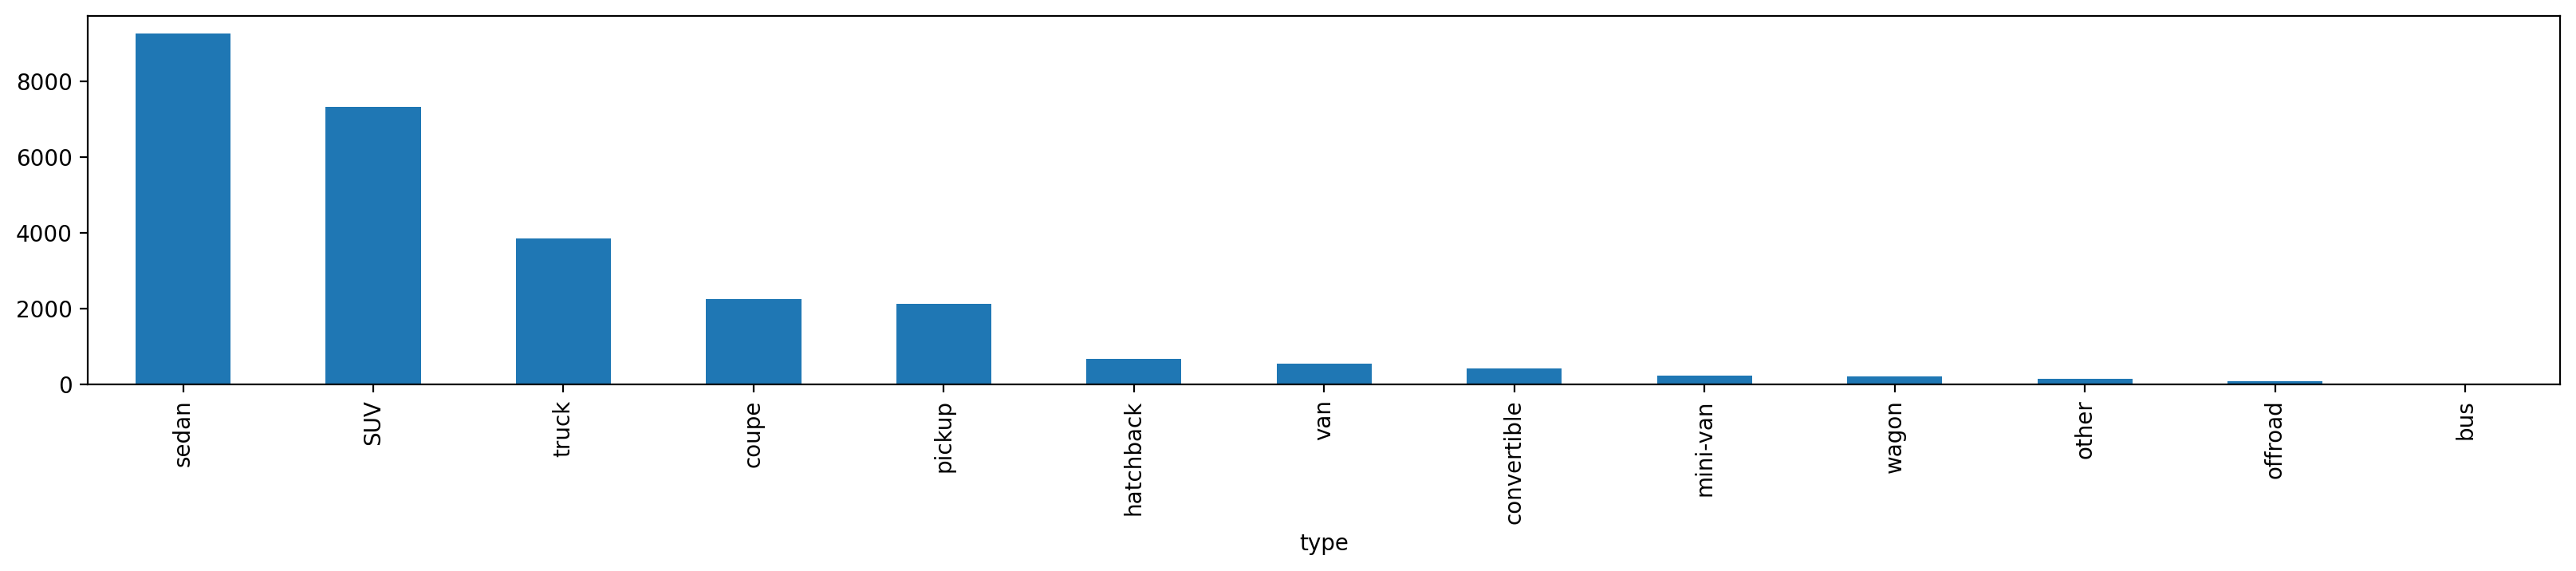

In [117]:
train.type.value_counts().plot(kind="bar", figsize=(20, 3))

<Axes: xlabel='type'>

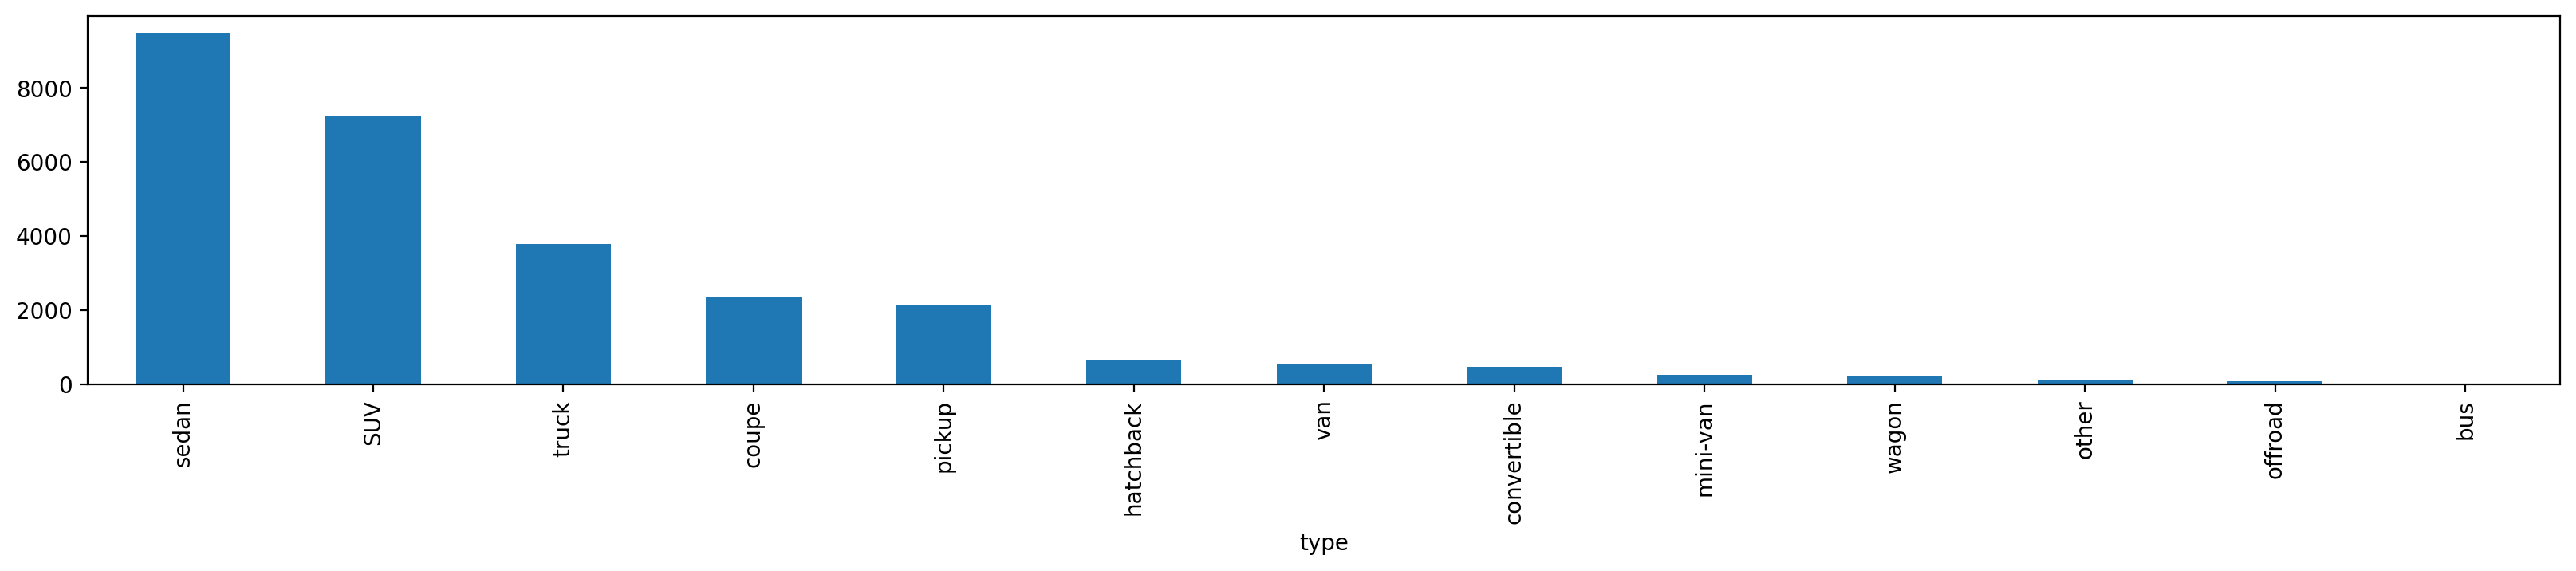

In [120]:
test.type.value_counts().plot(kind="bar", figsize=(20, 3))

### transmission (変速機)

In [118]:
# 3種類
train.transmission.nunique(), test.transmission.nunique()

(3, 3)

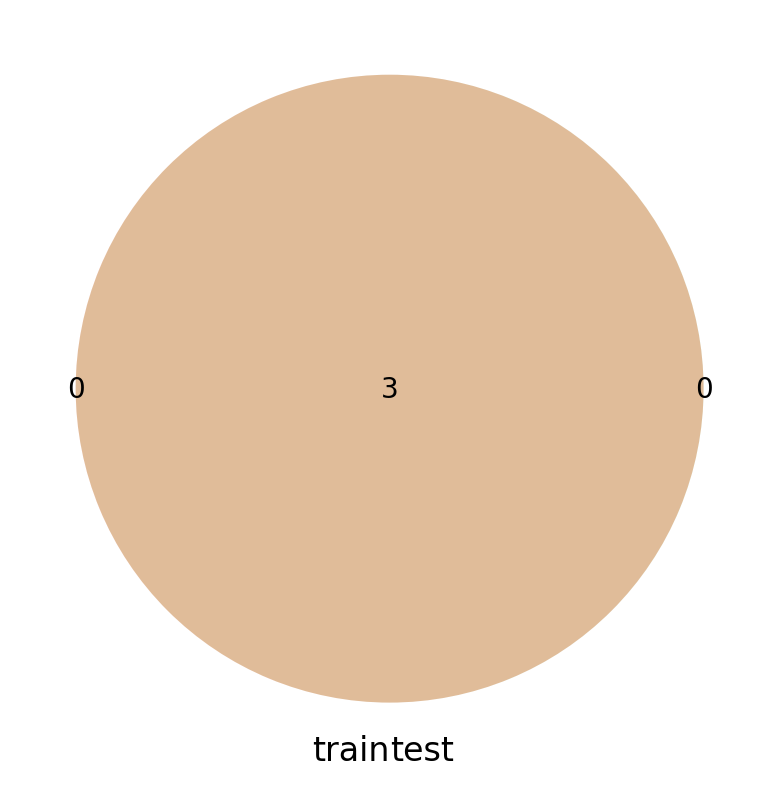

In [119]:
# train/test で全て同じ, 欠損あり
venn2([set(train.transmission), set(test.transmission)], set_labels = ("train", "test"))

<Axes: ylabel='count'>

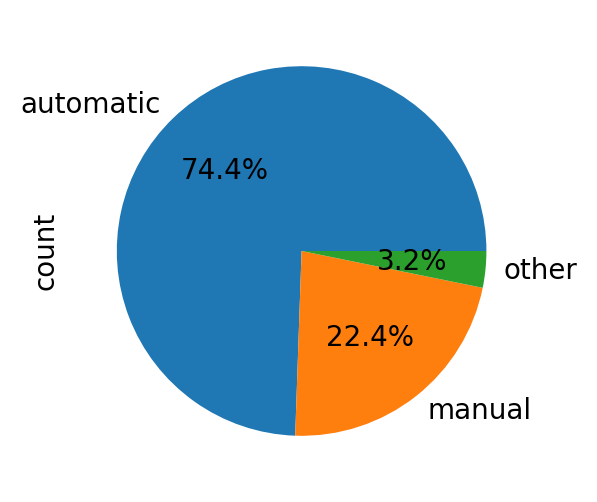

In [124]:
train.transmission.value_counts().plot(kind="pie", figsize=(5, 3), autopct="%1.1f%%")

### size (大きさ)

In [126]:
# 9種類
train["size"].nunique(), test["size"].nunique()

(9, 9)

In [136]:
# 4種類
train["size"].map(lambda x: x.translate(str_map)).nunique(), test["size"].map(lambda x: x.translate(str_map)).nunique()

(4, 4)

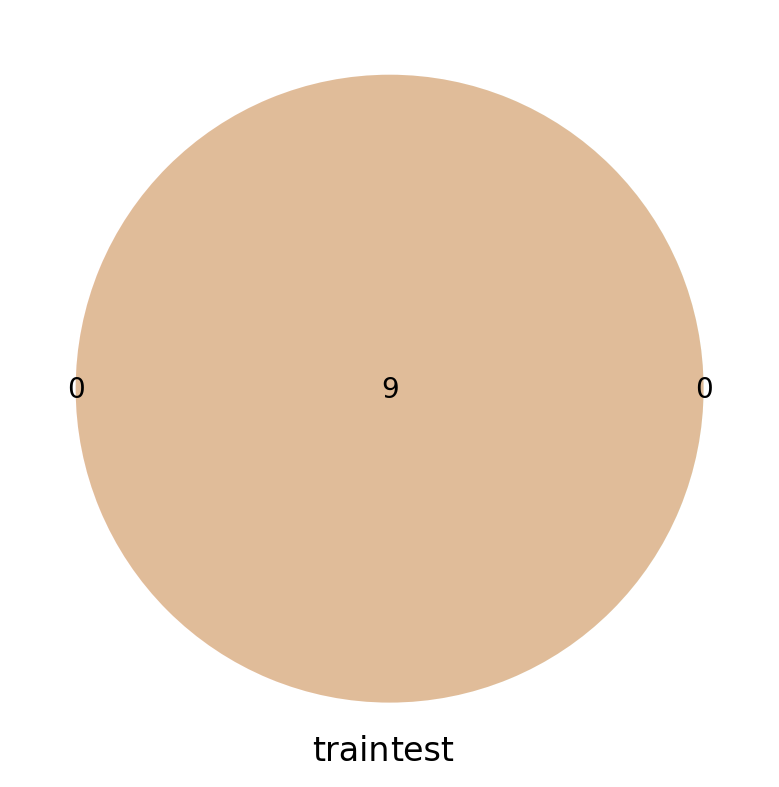

In [127]:
# train/test で全て同じ
venn2([set(train["size"]), set(test["size"])], set_labels = ("train", "test"))

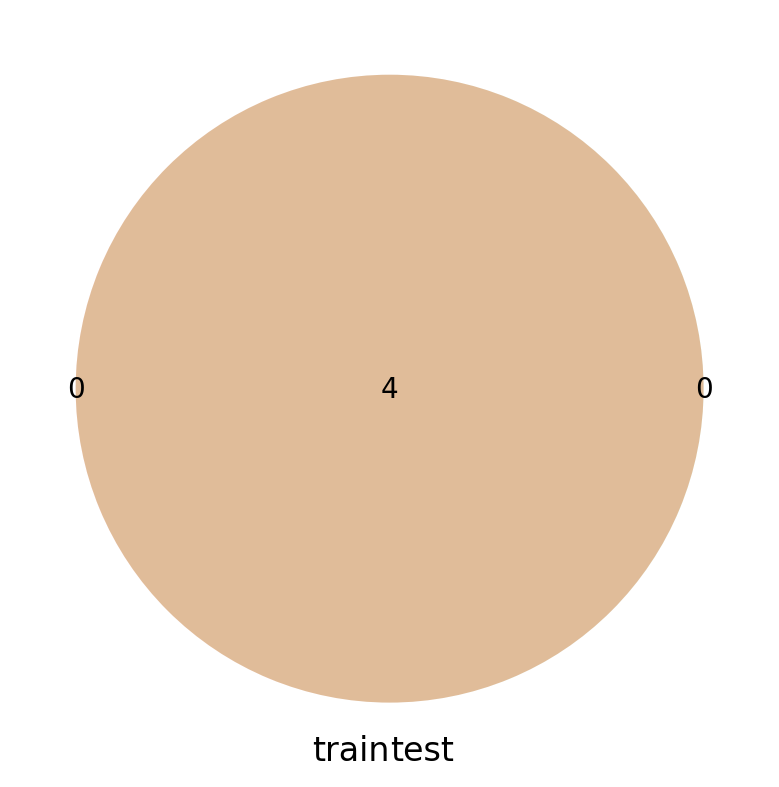

In [138]:
# train/test で全て同じ
venn2([set(train["size"].map(lambda x: x.translate(str_map))), set(test["size"].map(lambda x: x.translate(str_map)))], set_labels = ("train", "test"))

In [129]:
train["size"].value_counts()

size
full-size      14585
mid-size        9371
compact         3352
sub-compact      132
fullーsize         42
midーsize          35
full−size          9
mid−size           5
subーcompact        1
Name: count, dtype: int64

In [134]:
str_map = str.maketrans("ー−", "--")

In [135]:
train["size"].map(lambda x: x.translate(str_map)).value_counts()

size
full-size      14636
mid-size        9411
compact         3352
sub-compact      133
Name: count, dtype: int64

<Axes: ylabel='count'>

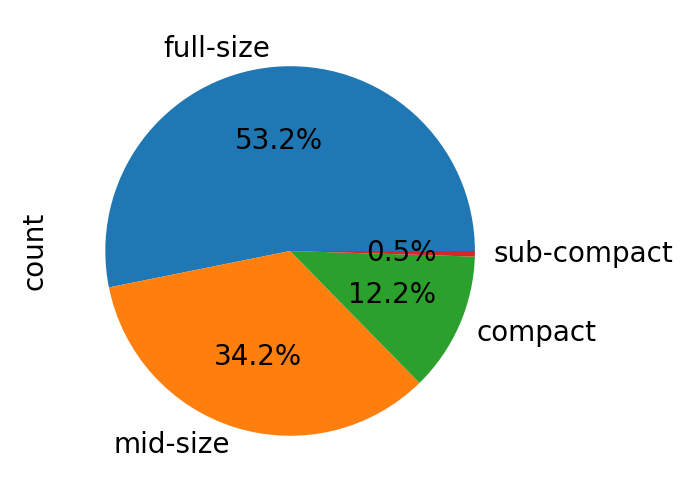

In [139]:
train["size"].map(lambda x: x.translate(str_map)).value_counts().plot(kind="pie", figsize=(5, 3), autopct="%1.1f%%")

<Axes: ylabel='count'>

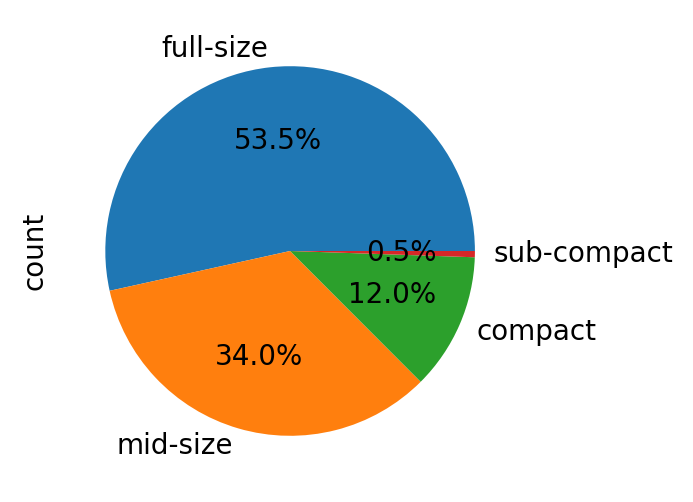

In [140]:
test["size"].map(lambda x: x.translate(str_map)).value_counts().plot(kind="pie", figsize=(5, 3), autopct="%1.1f%%")

### drive (駆動方式)

In [141]:
# 3種類
train.drive.nunique(), test.drive.nunique()

(3, 3)

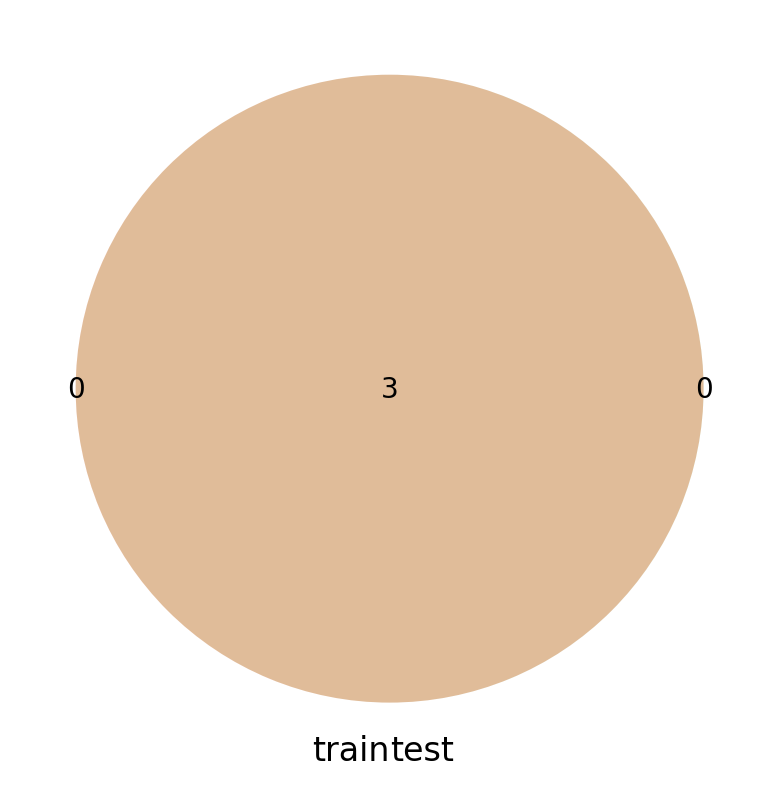

In [142]:
# train/test で全て同じ
venn2([set(train.drive), set(test.drive)], set_labels = ("train", "test"))

<Axes: ylabel='count'>

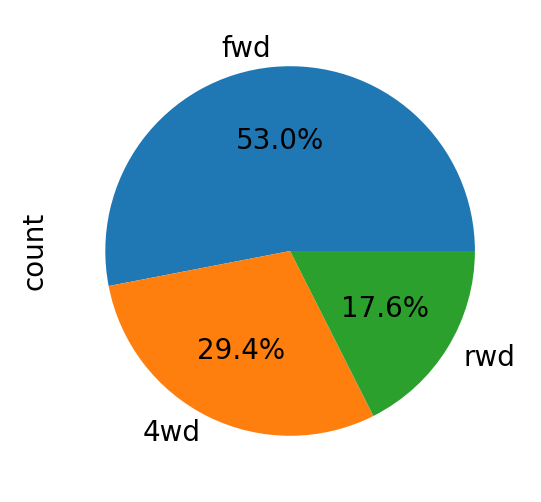

In [143]:
train.drive.value_counts().plot(kind="pie", figsize=(5, 3), autopct="%1.1f%%")

<Axes: ylabel='count'>

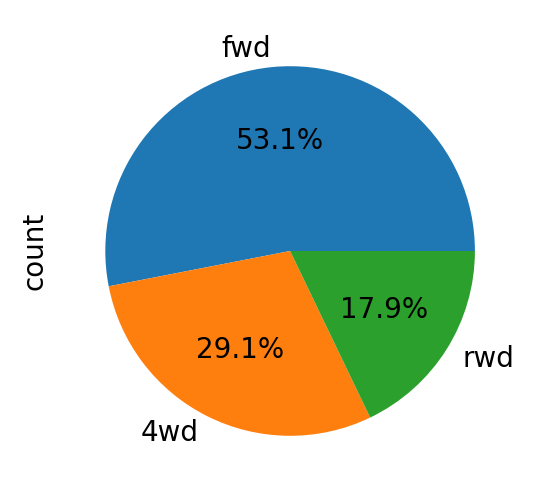

In [144]:
test.drive.value_counts().plot(kind="pie", figsize=(5, 3), autopct="%1.1f%%")

### paint_color (色)

In [145]:
# 12種類
train.paint_color.nunique(), test.paint_color.nunique()

(12, 12)

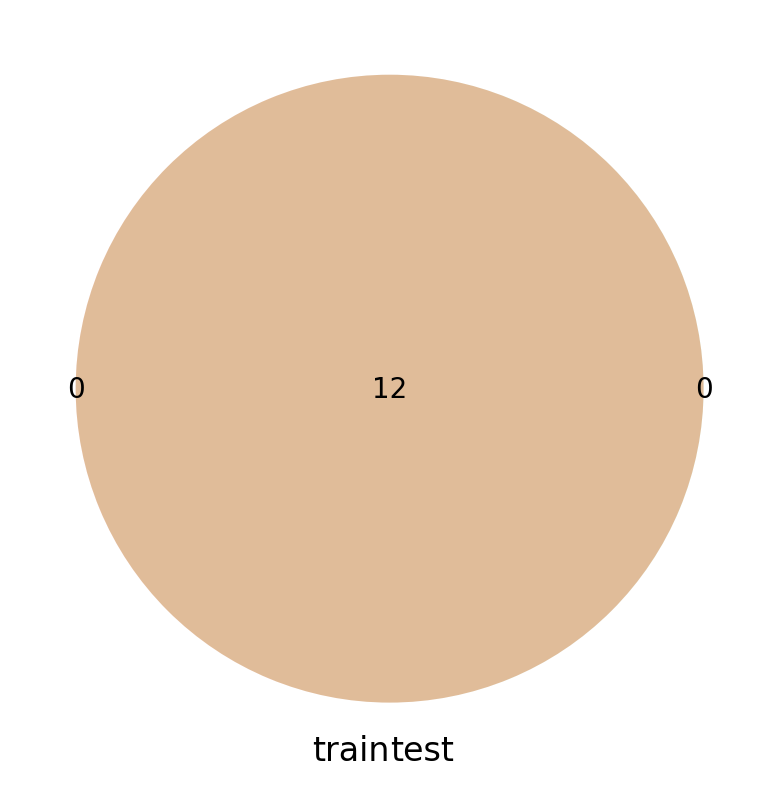

In [146]:
# train/test で全て同じ
venn2([set(train.paint_color), set(test.paint_color)], set_labels = ("train", "test"))

<Axes: xlabel='paint_color'>

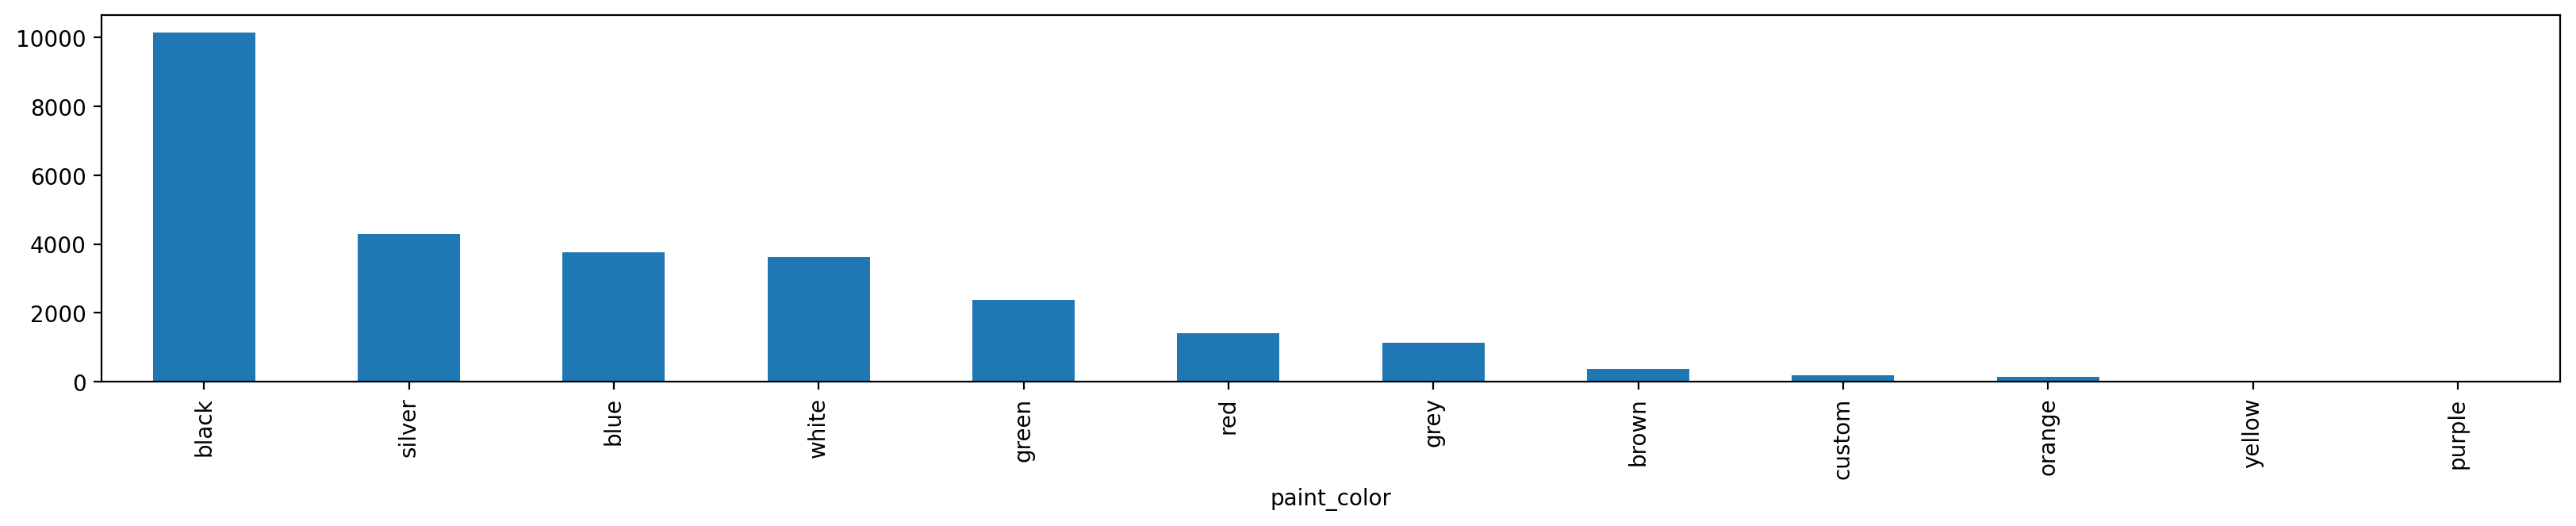

In [147]:
train.paint_color.value_counts().plot(kind="bar", figsize=(20, 3))

<Axes: xlabel='paint_color'>

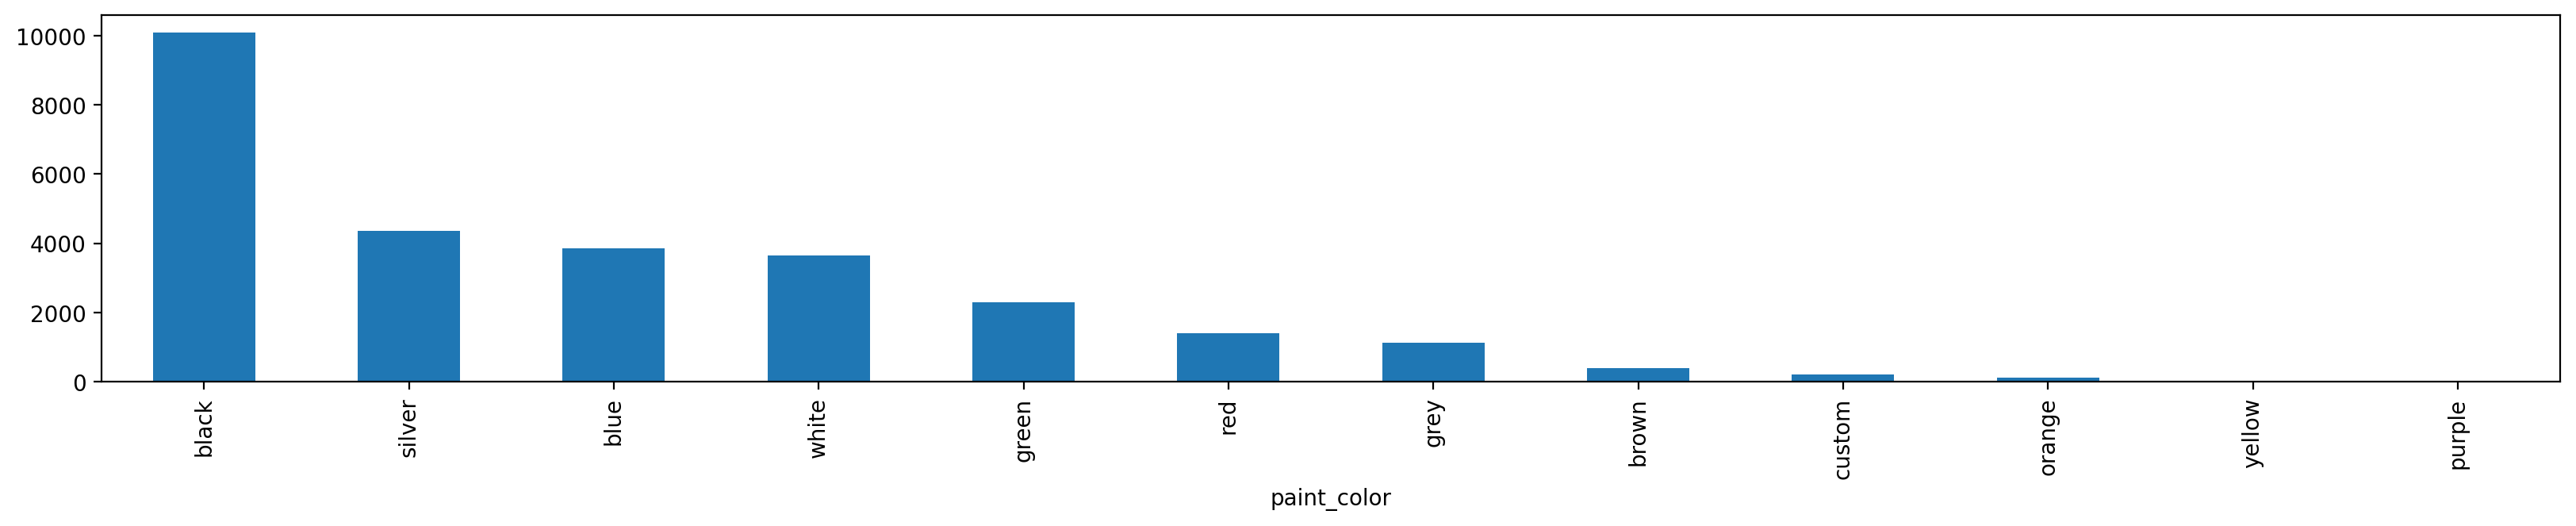

In [148]:
test.paint_color.value_counts().plot(kind="bar", figsize=(20, 3))

### condition (状態)

In [149]:
# 6種類
train.condition.nunique(), test.condition.nunique()

(6, 6)

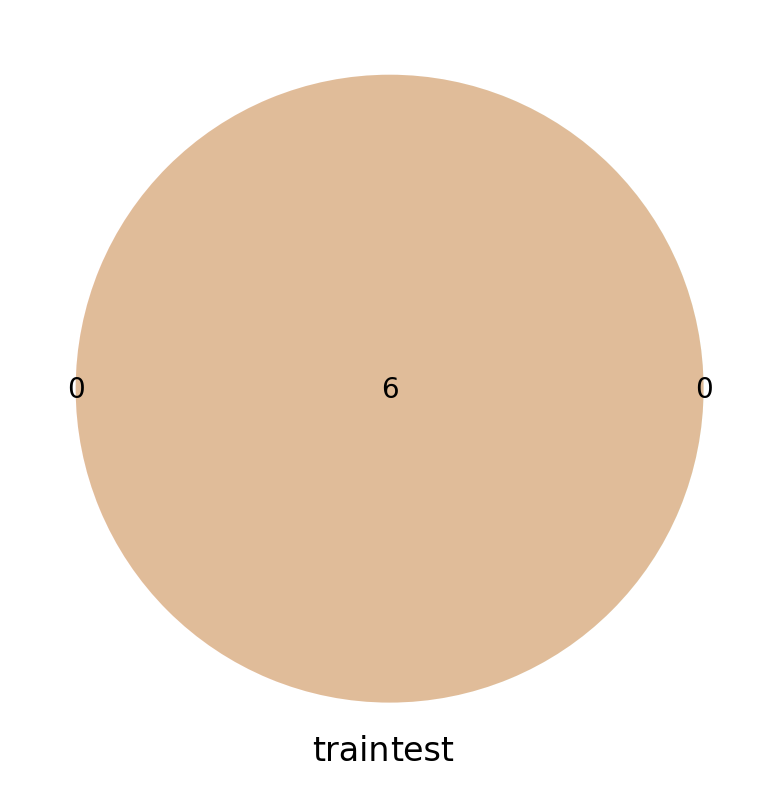

In [150]:
# train/test で全て同じ
venn2([set(train.condition), set(test.condition)], set_labels = ("train", "test"))

<Axes: xlabel='condition'>

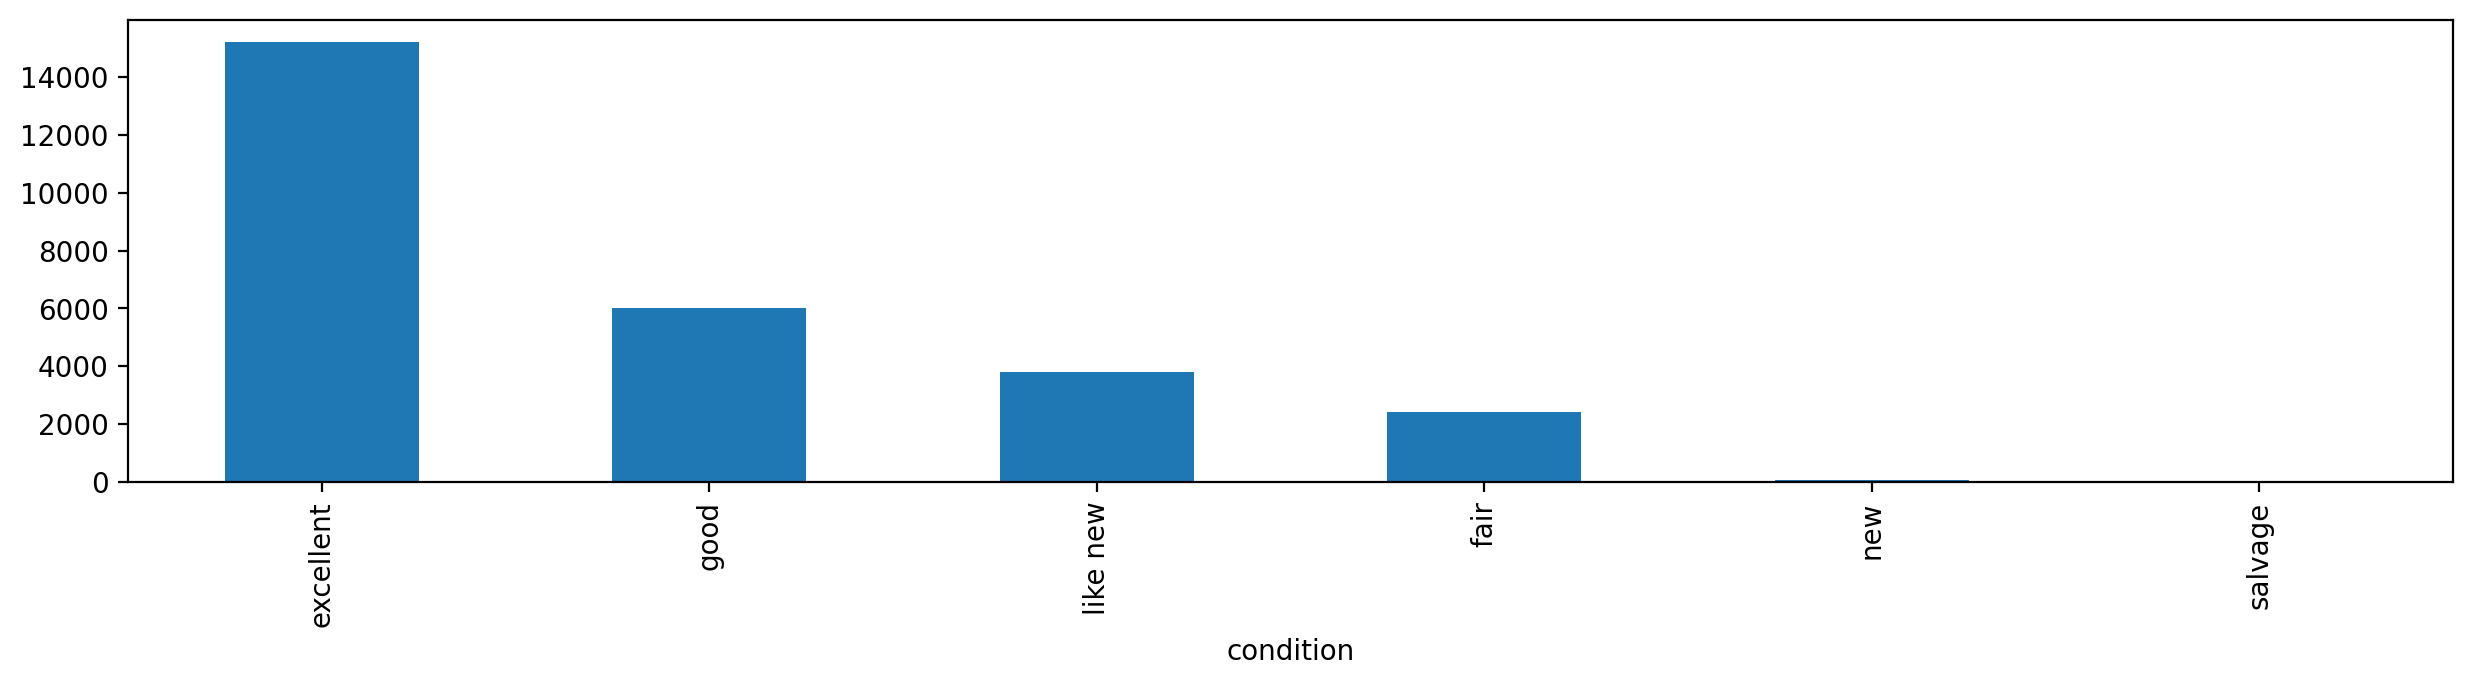

In [152]:
train.condition.value_counts().plot(kind="bar", figsize=(15, 3))

<Axes: xlabel='condition'>

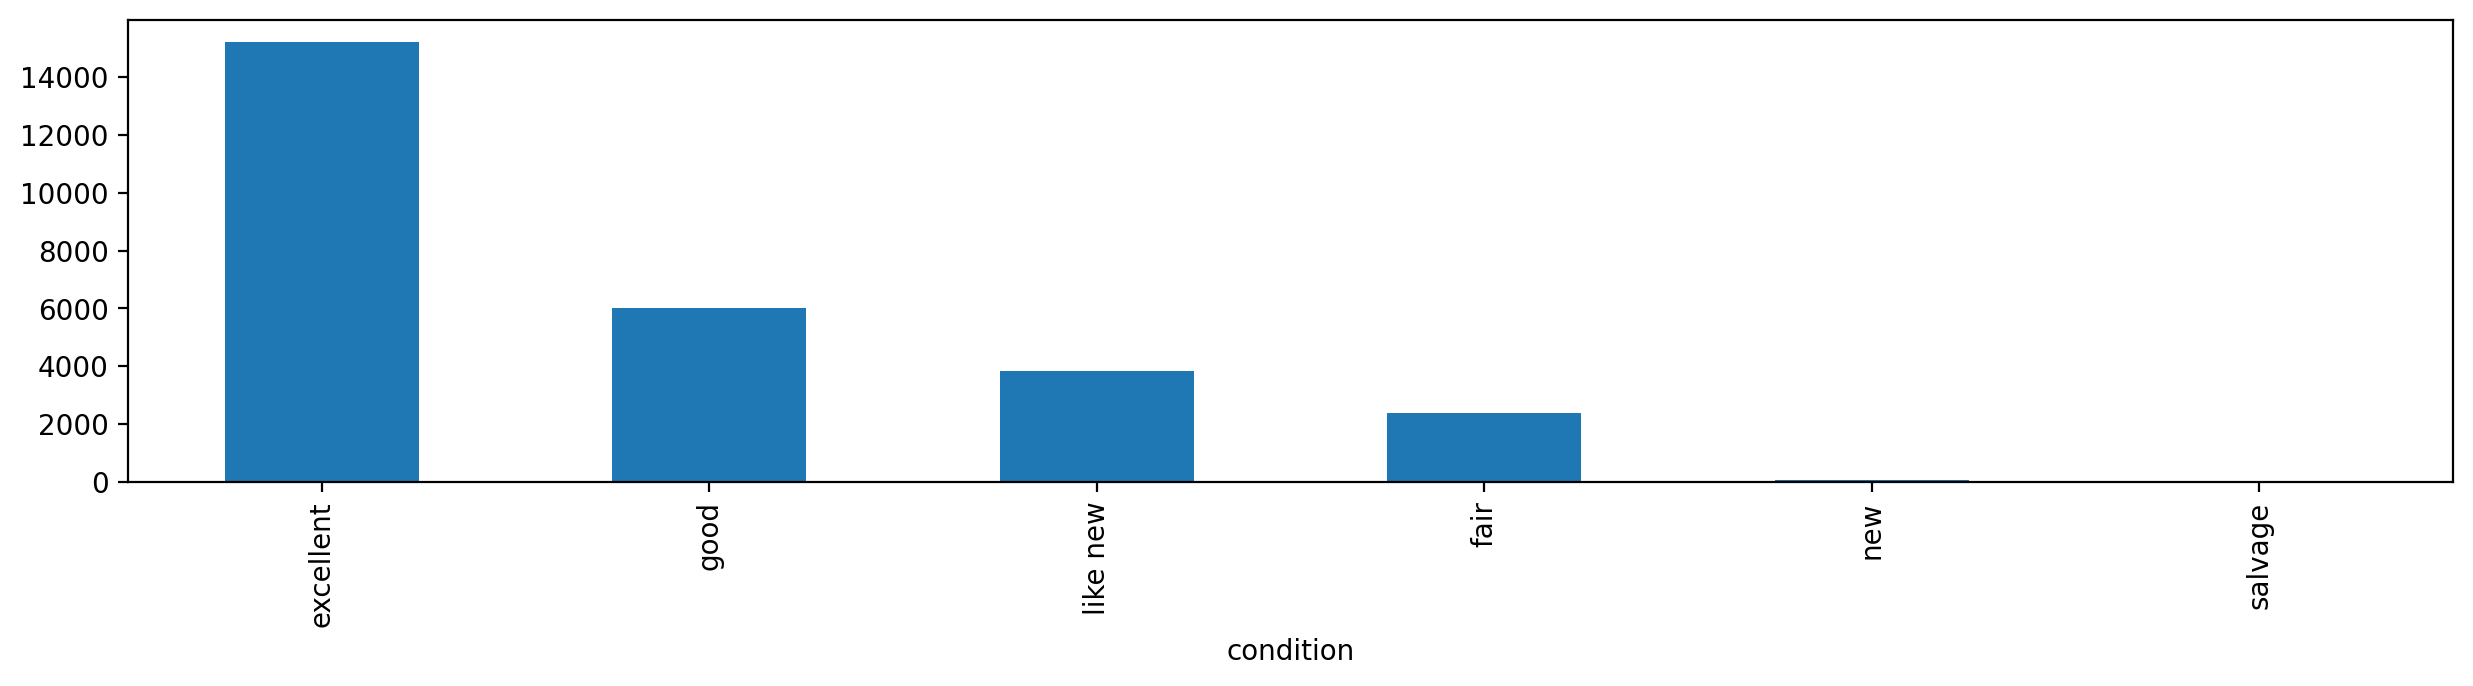

In [155]:
test.condition.value_counts().plot(kind="bar", figsize=(15, 3))

### cylinders (気筒数)

In [153]:
# 8種類
train.cylinders.nunique(), test.cylinders.nunique()

(8, 8)

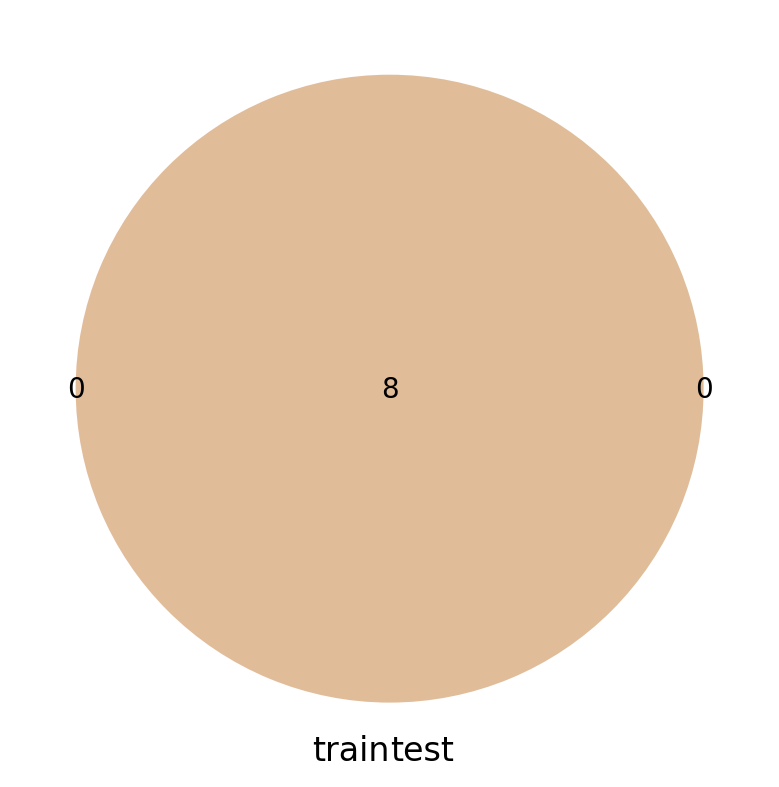

In [154]:
# train/test で全て同じ
venn2([set(train.cylinders), set(test.cylinders)], set_labels = ("train", "test"))

<Axes: xlabel='cylinders'>

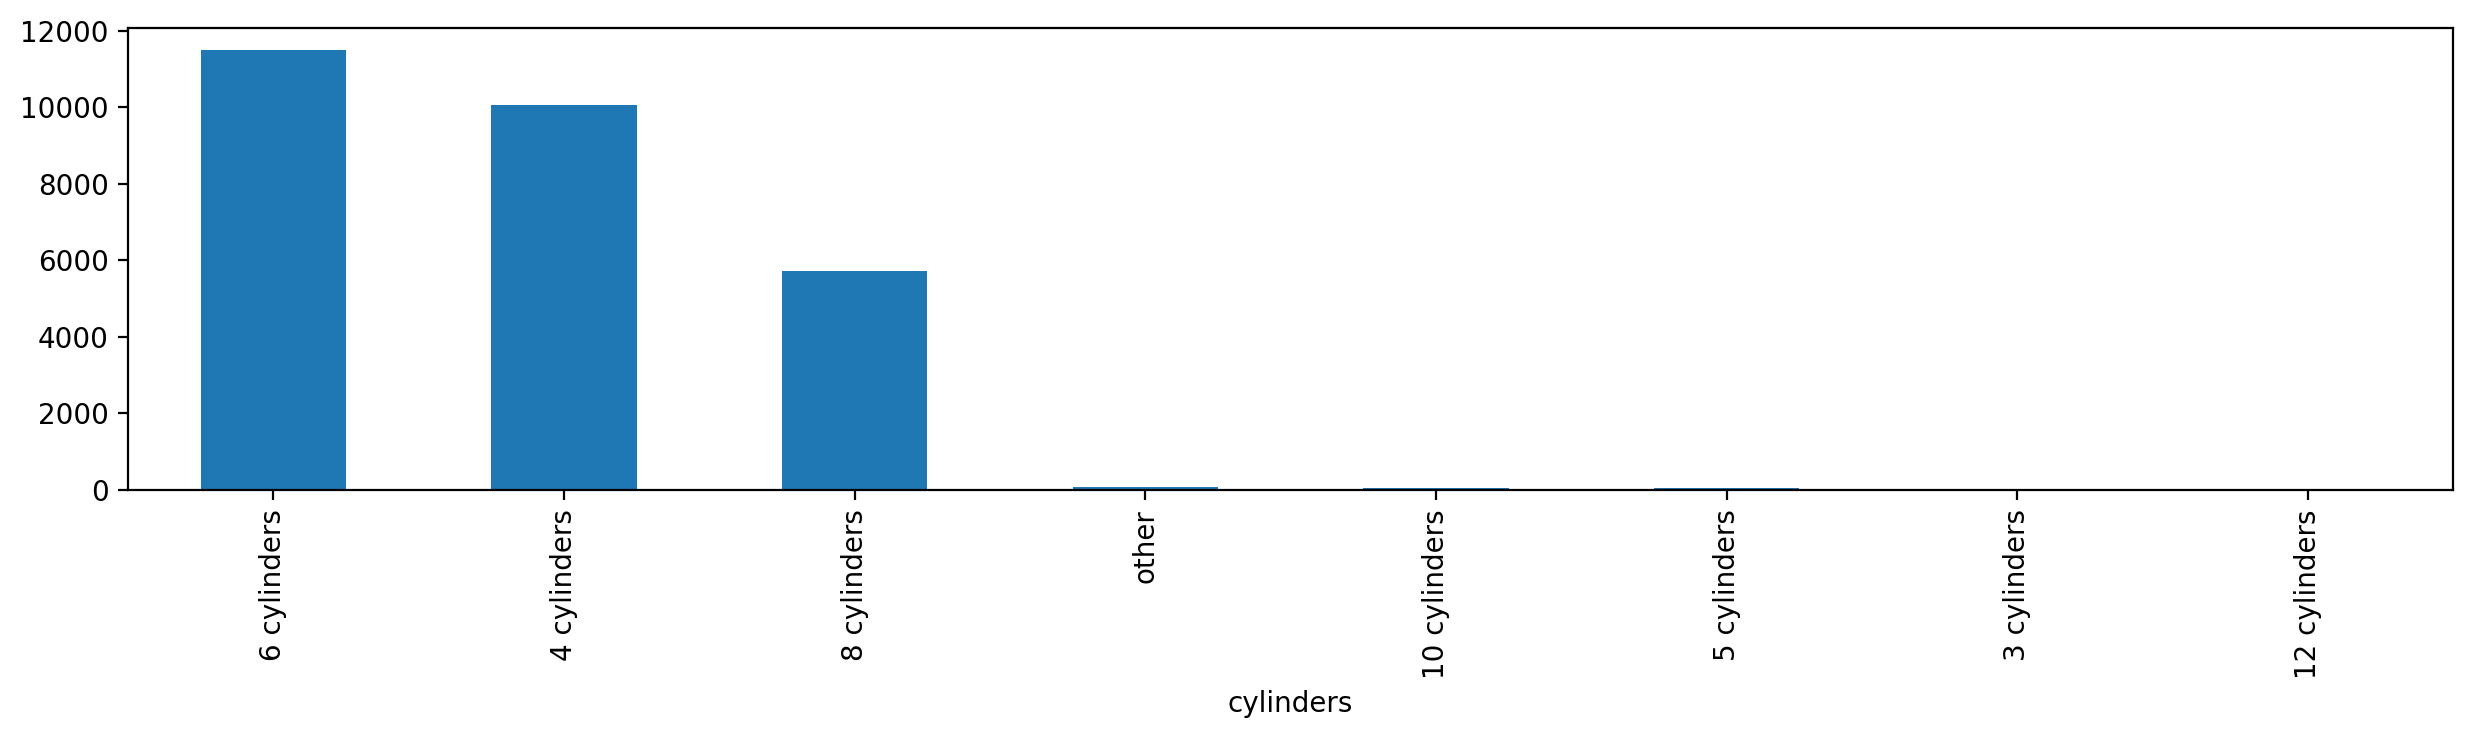

In [156]:
train.cylinders.value_counts().plot(kind="bar", figsize=(15, 3))

<Axes: xlabel='cylinders'>

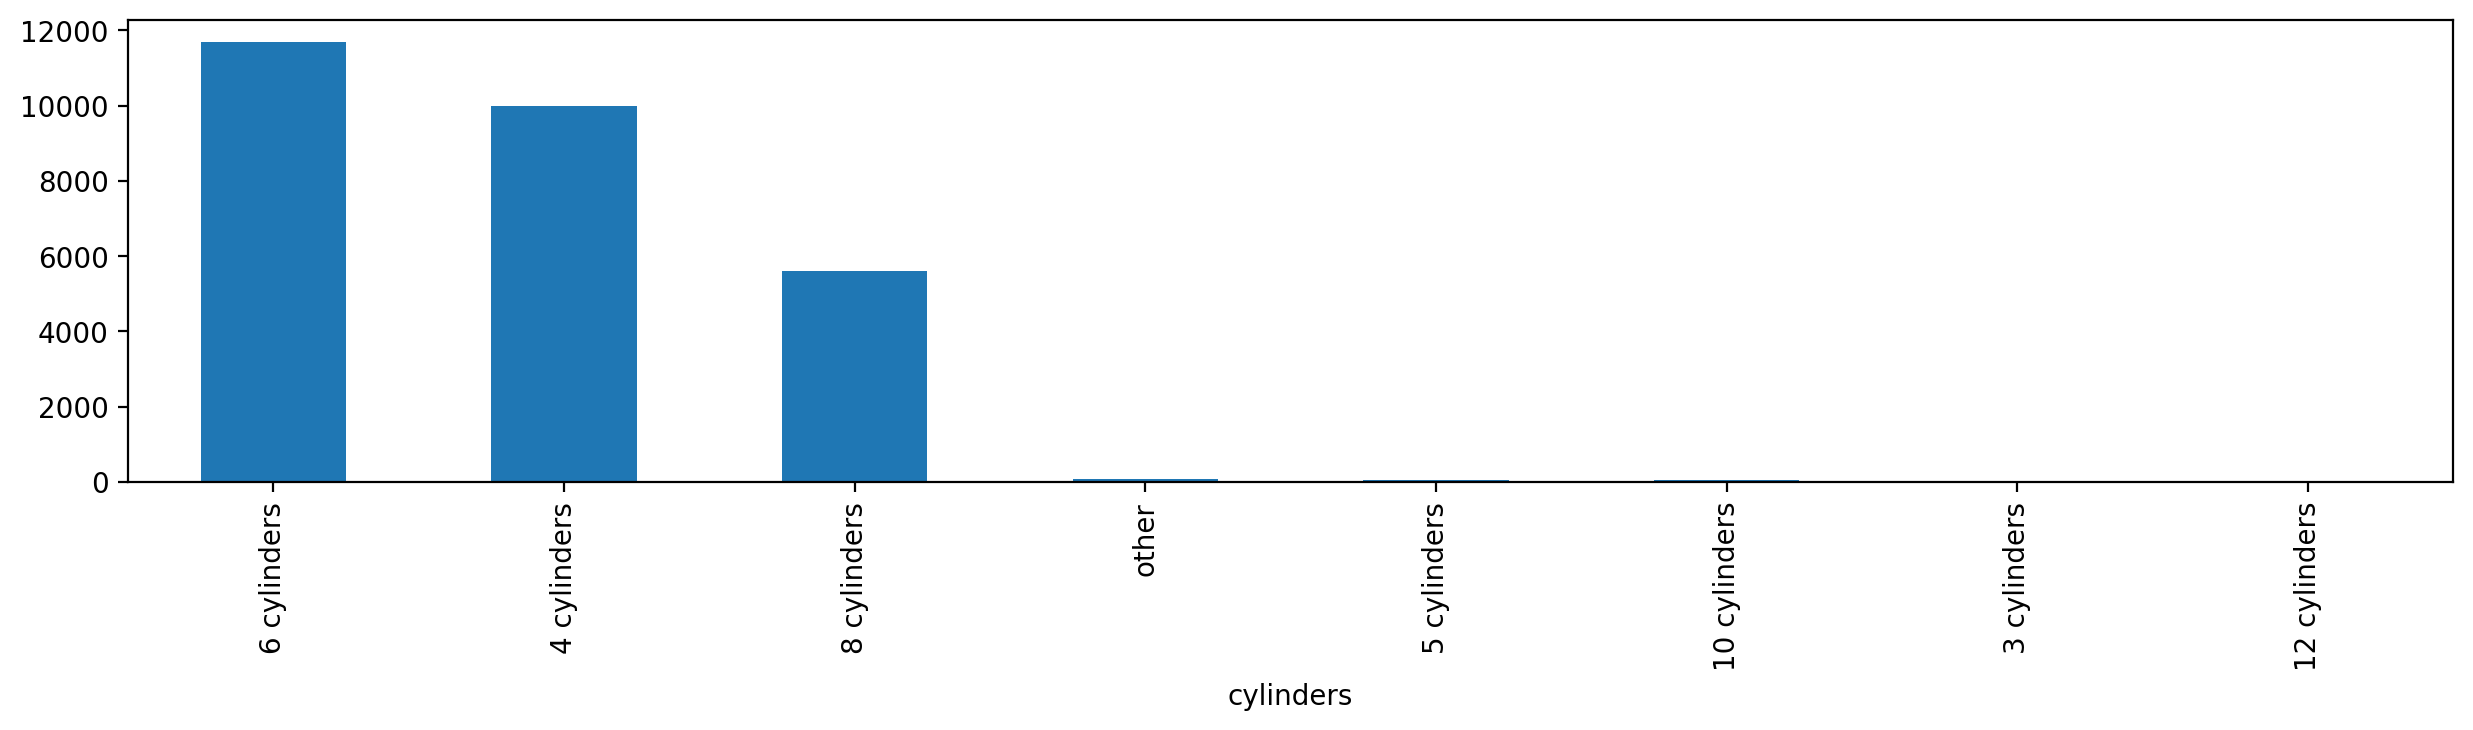

In [157]:
test.cylinders.value_counts().plot(kind="bar", figsize=(15, 3))

### fuel (使用するガソリンの種類)

In [158]:
# 5種類
train.fuel.nunique(), test.fuel.nunique()

(5, 5)

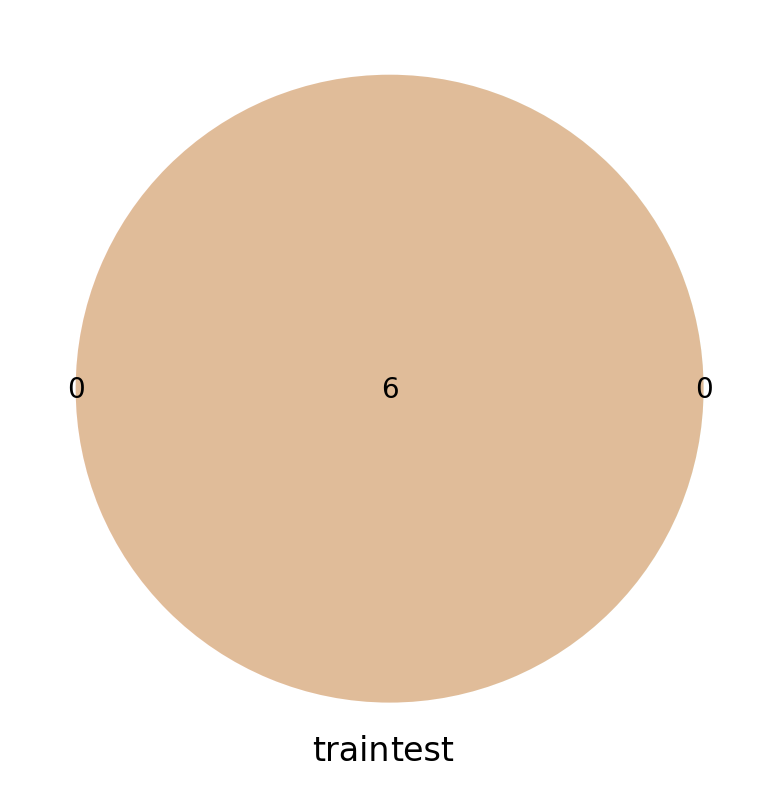

In [159]:
# train/test で全て同じ
venn2([set(train.fuel), set(test.fuel)], set_labels = ("train", "test"))

<Axes: xlabel='fuel'>

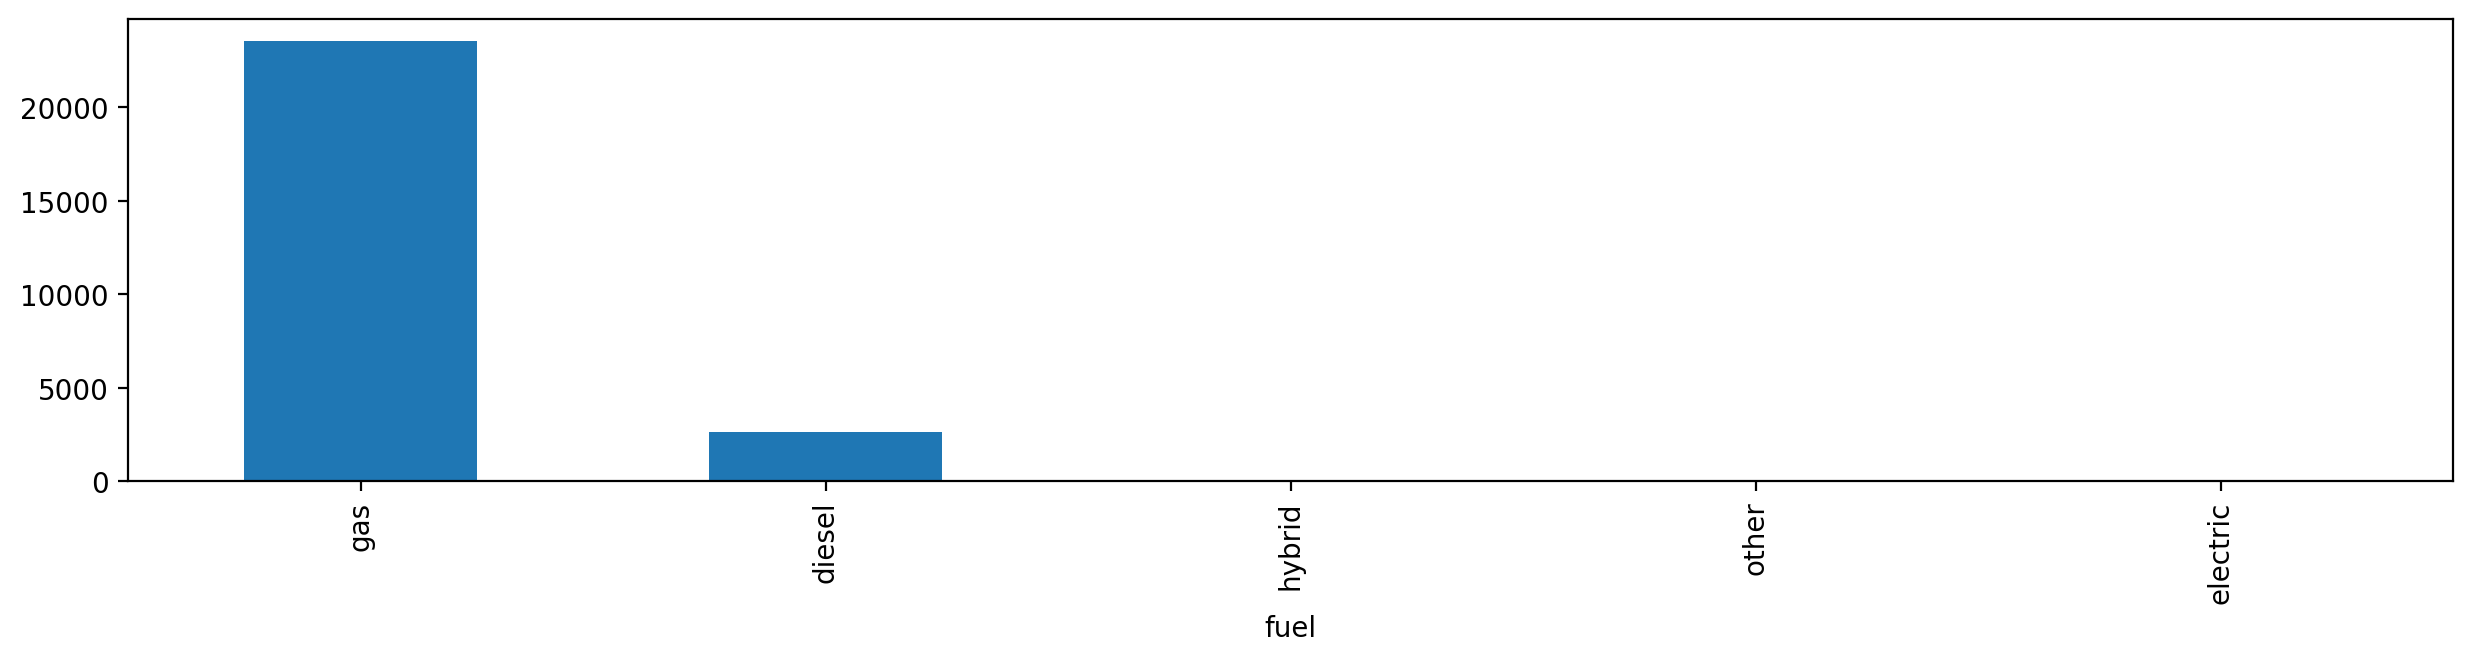

In [161]:
train.fuel.value_counts().plot(kind="bar", figsize=(15, 3))

<Axes: xlabel='fuel'>

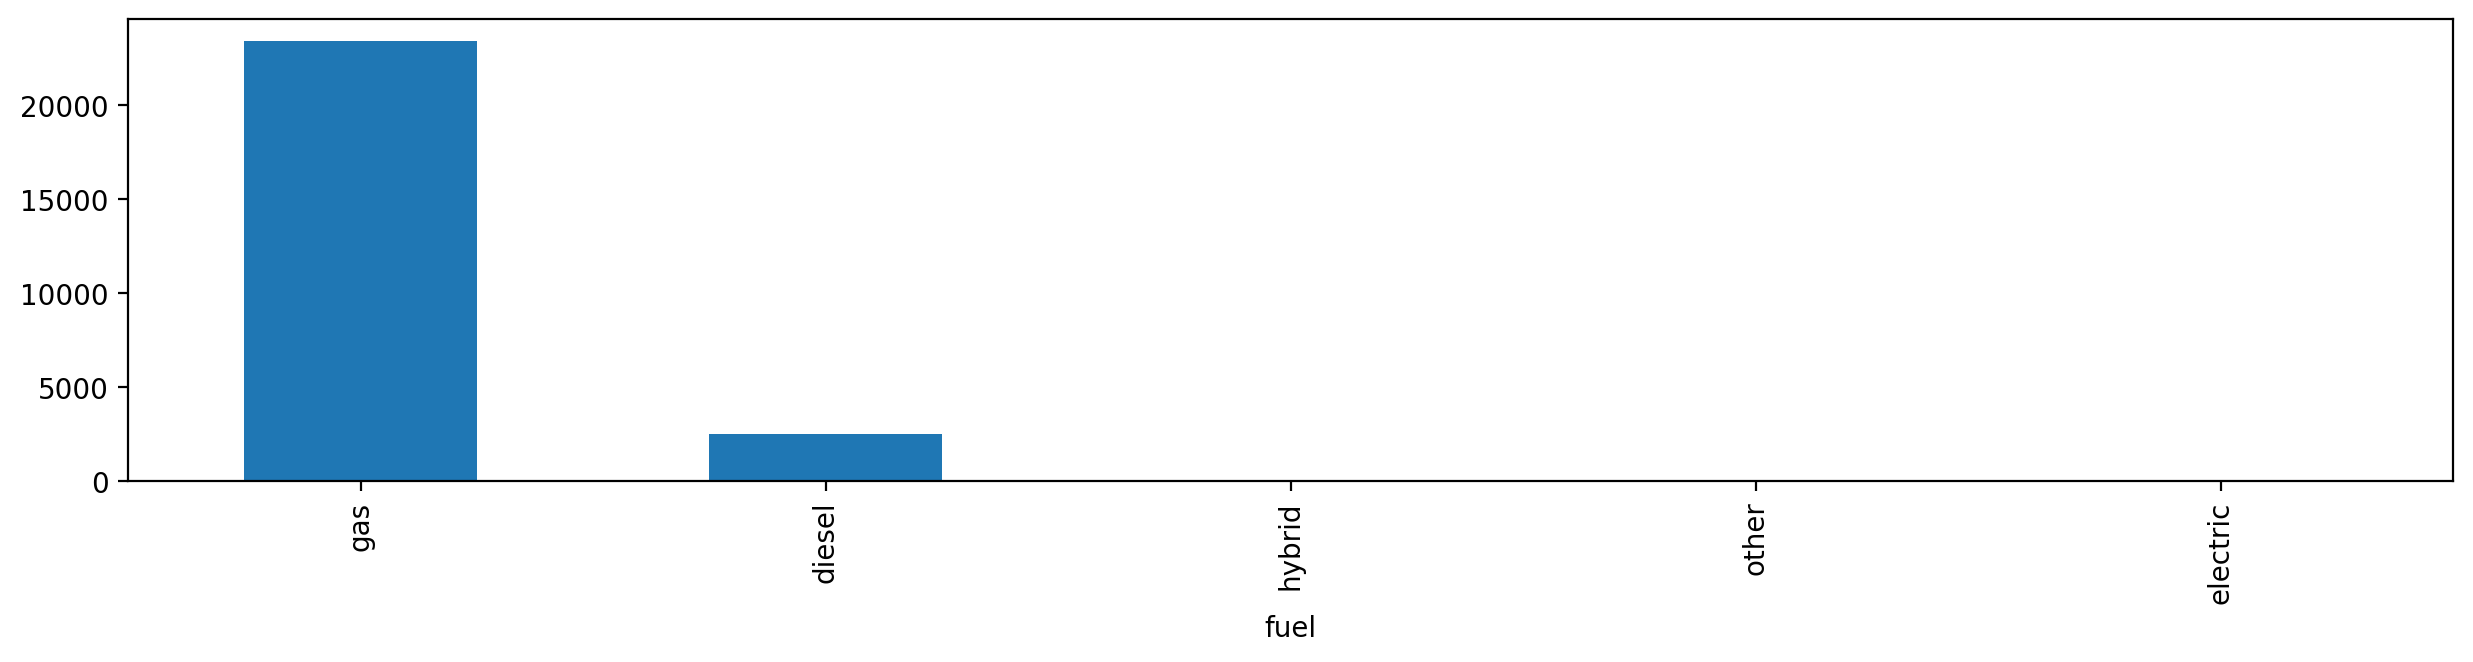

In [162]:
test.fuel.value_counts().plot(kind="bar", figsize=(15, 3))

### title_status (所有権の状態)
- title: 車両の所有権証明書のこと

In [163]:
# 6種類
train.title_status.nunique(), test.title_status.nunique()

(6, 6)

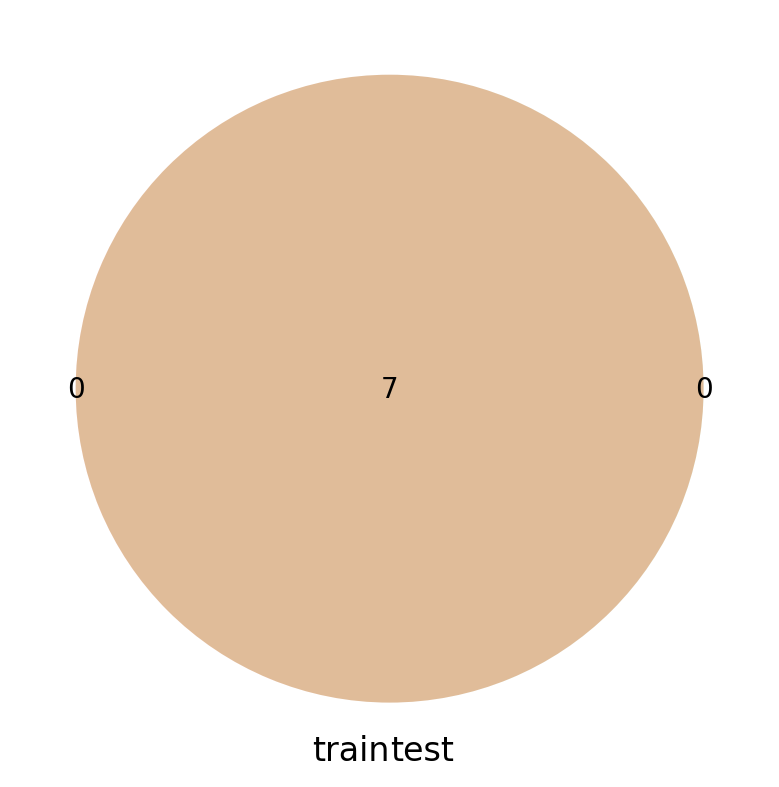

In [164]:
# train/test で全て同じ
venn2([set(train.title_status), set(test.title_status)], set_labels = ("train", "test"))

- clean (clear): 売却に関して何も負荷がない状態, 買う側からしたら最も好ましい, ローンを組める唯一の状態
- rebuilt: rebuildされた状態, 安全検査を通ってれば公道を走行できる
- salvage: 重大な事故や修理、盗難により大きく価値が下がった状態
- lien: 先取特権のこと
- parts only: パーツしかない状態？
- missing: 所有者に関する書類が紛失してる状態？

<Axes: xlabel='title_status'>

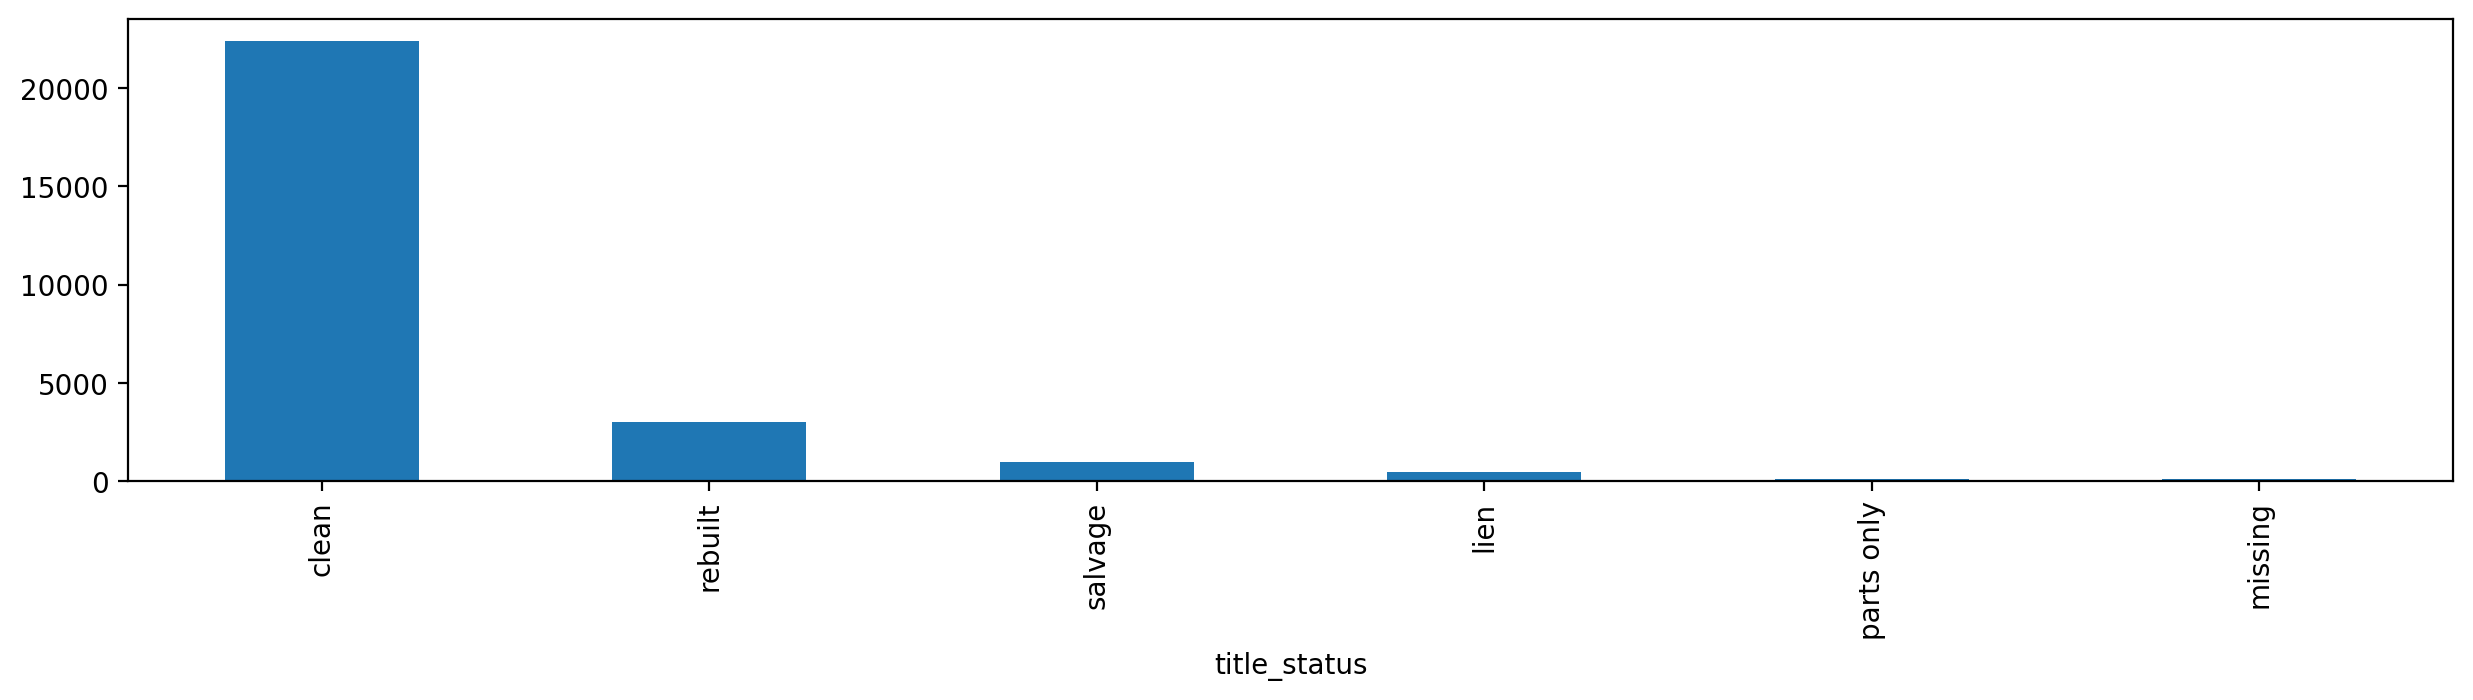

In [165]:
train.title_status.value_counts().plot(kind="bar", figsize=(15, 3))

<Axes: xlabel='title_status'>

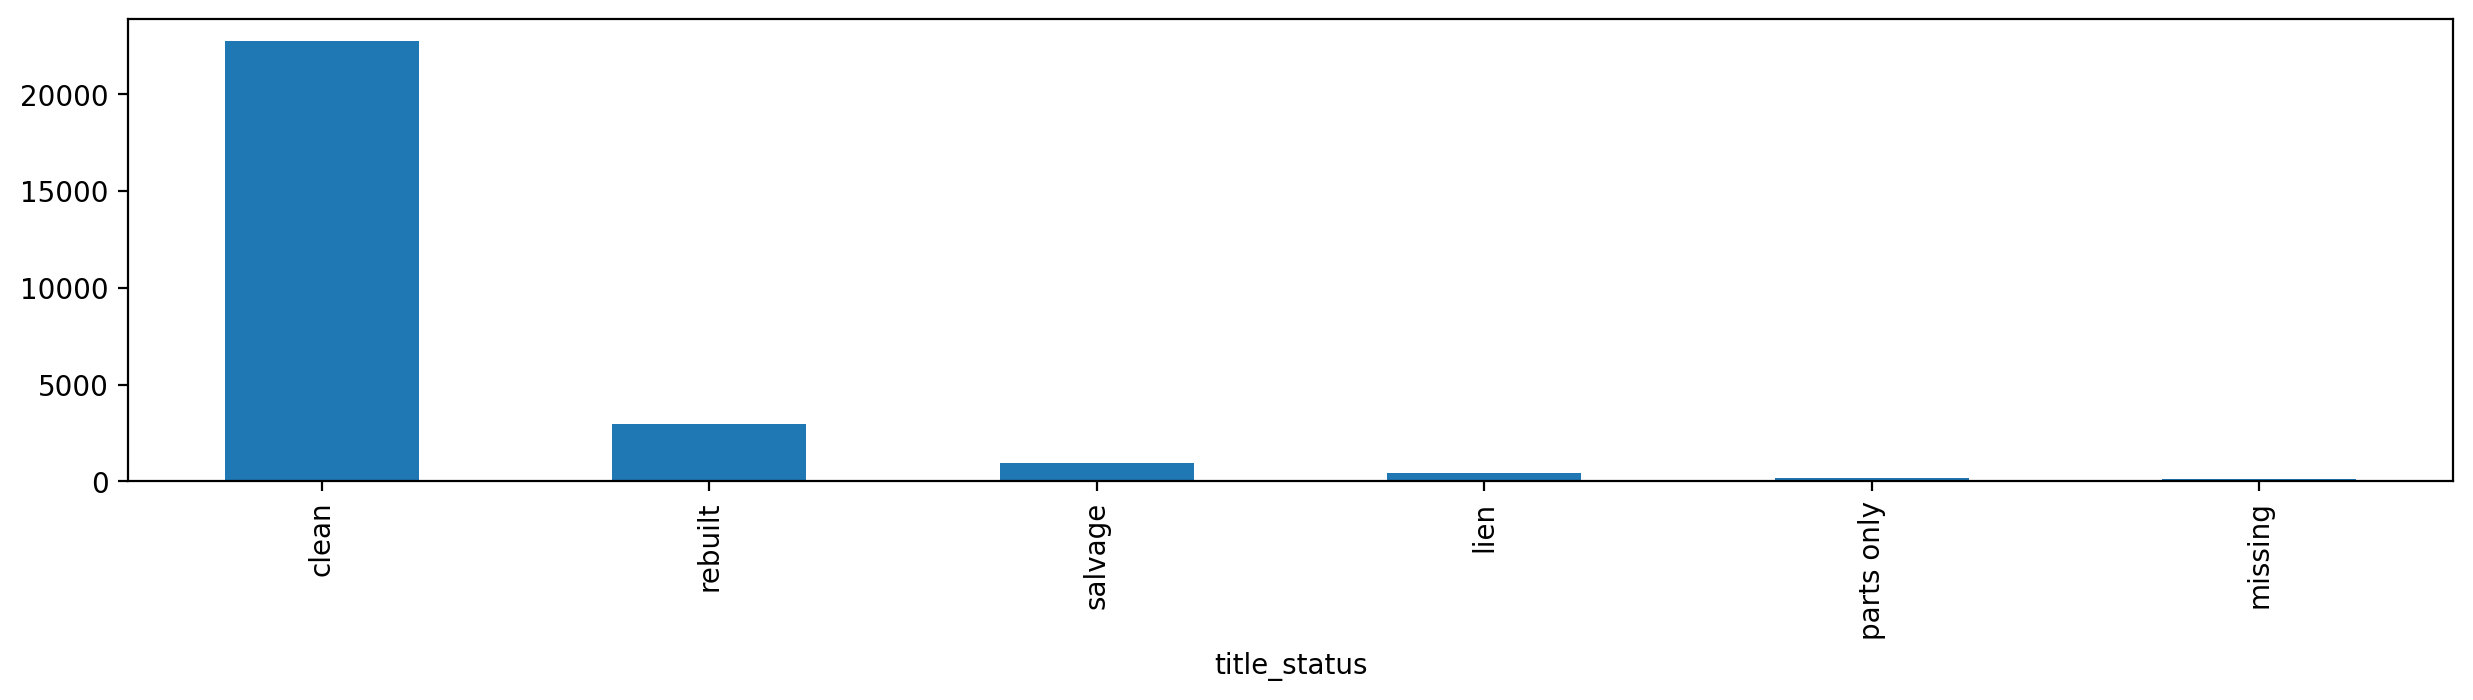

In [168]:
test.title_status.value_counts().plot(kind="bar", figsize=(15, 3))

In [167]:
train.groupby("title_status").price.describe()

,count,mean,std,min,25%,50%,75%,max
title_status,,,,,,,,
clean,22365.0,13276.948312,10979.958397,1004.0,5595.00,8959.0,18970.00,96818.0
lien,465.0,17082.879570,12411.808968,1083.0,7162.00,14832.0,21949.00,81011.0
missing,124.0,9365.072581,9369.456615,1080.0,3215.75,5520.0,11197.75,55442.0
parts only,133.0,11581.669173,9791.184545,1489.0,4756.00,7421.0,16027.00,52345.0
rebuilt,3004.0,14823.253329,10457.320638,1156.0,6966.75,11849.5,20331.50,86915.0
salvage,985.0,12351.056853,10028.630372,1008.0,5354.00,8753.0,17436.00,67982.0
